In [1]:
from scipy.stats import qmc
import pandas as pd
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import shutil
import os
from sklearn.metrics import mean_squared_error
from math import sqrt
import subprocess
import warnings
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simps
import geopandas as gpd
from matplotlib.colors import ListedColormap
import contextily as ctx
import matplotlib.colors as mcolors
warnings.filterwarnings("ignore")

### In this Notebook we run the the tree removal scenario on the all forest baseline. removing trees in 500m reaches. Then we analyze the results and create figures

# Overview
- Replace forested landcover with grass buffer in 500m reach, narrow each node by 20% in the newly forested reach
- run model, move to next 500m reach, and so on for the 18.5 km study section
- After running all the models, extract information about each reach including average aziumth, before/after shade values, width, gradient, and average velocity.
- determine the 'Thermal Restoration Index' of a reach based on the difference in longitudinal profile between the restored reach and the all grass baseline.
- create maps showing important attributes about each reach, including width, shade, and Thermal Restoation Index.
- Regression analysis of how different reach attributes may or may not effect the thermal restoration potential of a reach. 

In [2]:
#reading in data with relative paths so that it can be used by others who clone repository from github
#os.chdir(os.getcwd())
script_dir = os.getcwd()

# the baseline were useing for treeplanting scenatio is all grass and its been extended 5km 
base_source_folder = os.path.abspath(os.path.join(script_dir, 'scenarios','scenario_inputs', 'vegetation_buffers','july_allforest_extended'))

#Temperature Observations folder
observed_temp_path = os.path.abspath(os.path.join(script_dir, 'observations', 'TemperatureDataObs'))
#Temperature observations
obs = pd.read_csv(os.path.join(observed_temp_path, 'HourlySummer23Master_riverkm.csv'))

#reading in a model run without topographic shading, for use in determining whether a reach is forested or not
notopo_source_folder = os.path.abspath(os.path.join(script_dir, 'scenarios','scenario_inputs', 'notopo_models', 'July_notopo_extended'))

#lc data scenario with buffer, to be used for adding forest to previously foresgrassyted areas
grassbuffer_source_folder = os.path.abspath(os.path.join(script_dir, 'scenarios','scenario_inputs','vegetation_buffers', 'july_grassbuffer'))


In [3]:
#getting date times for modeled outputs
control_file = pd.read_csv(os.path.join(base_source_folder, 'HeatSource_Control.csv'))
cc_start = control_file.loc[7]['VALUE']
cc_start = pd.to_datetime(cc_start)
cc_end = control_file.loc[8]['VALUE']
cc_end = pd.to_datetime(cc_end)
print('start is: '+ str(cc_start))
print('end is: '+ str(cc_end))
#reading observed hourly temps for model range (for joining datetimes)
#obs = pd.read_csv(r"D:\Ben_wd\THESIS\streamtemperature\WFK23\Summer23\mainstemhourly_km.csv")
obs["datetime"] = pd.to_datetime(obs["datetime"])
#obs_clip = obs[(obs["datetime"]>='07-01-2023') & (obs["datetime"]<'07-02-2023')]# + pd.DateOffset(1))]
obs_clip = obs[(obs["datetime"]>=cc_start) & (obs["datetime"]<cc_end + pd.DateOffset(1))]

# Make observed temps compatible with heatsource outputs
obs_clip = obs_clip.dropna(axis=1)
obs_clip = obs_clip.set_index('datetime')
#obs_clip.columns = [float(col) for col in obs_clip.columns[2:]]
obs_clip.columns = [float(col) for col in obs_clip.columns]
#obs_clip.drop(19.2, axis=1, inplace=True)
obs_clip_mean = obs_clip.resample('D').mean()

start is: 2023-07-01 00:00:00
end is: 2023-07-31 00:00:00


In [4]:
# setting up the notopo dataframe so that we can determine which to add shade to, this is a rollover from a past script, and we dont necessarily need to use the notopo df-it was just more convenient
notopo_shade_df = pd.read_csv(os.path.join(notopo_source_folder, 'outputs\Shade.csv'), skiprows=6,
         usecols=range(1, 187))
notopo_shade_df.columns = [float(col) for col in notopo_shade_df.columns]
notopo_shade_df = notopo_shade_df.mean()
notopo_shade_df = pd.DataFrame(notopo_shade_df)
notopo_shade_df = notopo_shade_df.reset_index()
#notopo_shade_df.index = obs_clip_mean.index
notopo_shade_df.rename(columns={'index': 'NODE_ID', 0 : 'July Shade'}, inplace=True)
notopo_shade_df

NODE_ID  July Shade
0       23.5     0.72478
1       23.4     0.50270
2       23.3     0.16168
3       23.2     0.30936
4       23.1     0.22694
..       ...         ...
181      5.4     0.04334
182      5.3     0.10804
183      5.2     0.17680
184      5.1     0.18004
185      5.0     0.03350

[186 rows x 2 columns]

In [28]:
## add trees in 500m reach, widen if the node isnt previously forested

landcover = pd.read_csv(os.path.join(base_source_folder, 'inputs\WFK23_lcdata.csv'))
morphology = pd.read_csv(os.path.join(base_source_folder, 'inputs\WFK23_morphology.csv'))
landcover_notopo = pd.read_csv(os.path.join(notopo_source_folder, 'inputs\WFK23_lcdata.csv'))
grasslandcover = pd.read_csv(os.path.join(grassbuffer_source_folder, 'inputs\WFK23_lcdata.csv'))

changed_nodes = {}

for index, row in landcover.iterrows():
    km_start = row['STREAM_KM']
    
    #dont keep simulating once model gets to the extended portion
    if km_start == 5.0:
        break
    
    if isinstance(km_start, float) and km_start % .5 == 0:
        landcover_km = landcover.copy()# Create a copy of landcover DataFrame
        morphology_km = morphology.copy()
        
        
        print(km_start)
        #print('true')
        # if km_start == 18.0:
        #     continue
        km_end = km_start - .5  # Assuming km_end is one kilometer ahead of km_start
        # Copy base model folder and rename it
        original_folder_path = base_source_folder
        folder_name = f"reach_{km_start}"  # You can adjust the folder name as needed
        new_folder_name = f"folder_{km_start}"  # You can adjust the folder name as needed
        new_folder_path = os.path.abspath(os.path.join(script_dir, 'scenarios', 'scenario_outputs', 'july_treeremoval2', f'treeremoval{km_start}'))
        shutil.copytree(original_folder_path, new_folder_path) 


        landcover = pd.read_csv(os.path.join(new_folder_path, 'inputs\WFK23_lcdata.csv'))
        morphology = pd.read_csv(os.path.join(new_folder_path, 'inputs\WFK23_morphology.csv'))
        # change controlfile to reflect reach folder
        control_file = pd.read_csv(os.path.join(new_folder_path, 'HeatSource_Control.csv'))
        control_file.loc[2, 'VALUE'] = str(os.path.join(new_folder_path, "inputs\\"))
        control_file.loc[3, 'VALUE'] = str(os.path.join(new_folder_path, "outputs\\"))
        control_file.to_csv(os.path.join(new_folder_path, 'HeatSource_Control.csv'), index = False)

        reach_shade = notopo_shade_df[(notopo_shade_df['NODE_ID'] <= km_start) & (notopo_shade_df['NODE_ID']>=km_end)]
        print(km_start)
        changed_nodes[km_start] = []

        for index, row in reach_shade.iterrows():
            landcover_km.loc[index, landcover_km.columns[8:48]] = grasslandcover.loc[index, grasslandcover.columns[8:48]]
            landcover_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_lcdata.csv'), index = False)
            # if reach_shade.loc[index]['July Shade'] > .2:
            #     print('narrowing @: ', index)
                #narrow forested nodes

            # morphology_km.loc[index,morphology_km.columns[5]] = morphology_km.loc[index,morphology_km.columns[5]]*1.2
            morphology_km.loc[index,morphology_km.columns[5]] = morphology_km.loc[index,morphology_km.columns[5]]*1.2

            morphology_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_morphology.csv'), index = False)
            changed_nodes[km_start].append(index)


        os.chdir(new_folder_path)
        subprocess.run(['hs', 'run', '-t'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)


23.5
23.5
23.0
23.0
22.5
22.5


In [5]:
reaches = [27-(x / 2) for x in range(0, 37)]



In [6]:
base_shade_df = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Heat_SR6.csv'), skiprows=6, usecols=range(1, 274))
base_hourly_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='H', inclusive='left')  # Closed left ensures end date is exclusive
base_shade_df.columns = [float(col) for col in shade_df.columns]
base_shade_df.index = hourly_index
base_shade = base_shade_df.mean()
base_shade = pd.DataFrame(base_shade)
base_shade = base_shade.reset_index()
base_shade.rename(columns={'index': 'NODE_ID', 0 : 'Effective Shade %'}, inplace=True)
base_shade

NameError: name 'reach_source_folder' is not defined

In [12]:
values = [23.5-(x / 2) for x in range(0, 37)]

# Printing the list
print(values)

[23.5, 23.0, 22.5, 22.0, 21.5, 21.0, 20.5, 20.0, 19.5, 19.0, 18.5, 18.0, 17.5, 17.0, 16.5, 16.0, 15.5, 15.0, 14.5, 14.0, 13.5, 13.0, 12.5, 12.0, 11.5, 11.0, 10.5, 10.0, 9.5, 9.0, 8.5, 8.0, 7.5, 7.0, 6.5, 6.0, 5.5]


In [9]:
upstreamconstant_df

23.5     23.4     23.3     23.2     23.1     23.0  \
datetime                                                                   
2023-07-01 00:00:00  20.817  20.8091  20.8124  20.8112  20.8069  20.8100   
2023-07-01 01:00:00  20.484  20.4685  20.4767  20.4765  20.4612  20.4581   
2023-07-01 02:00:00  20.150  20.1441  20.1600  20.1685  20.1645  20.1670   
2023-07-01 03:00:00  19.841  19.8373  19.8539  19.8646  19.8659  19.8699   
2023-07-01 04:00:00  19.484  19.4899  19.5148  19.5333  19.5452  19.5541   
...                     ...      ...      ...      ...      ...      ...   
2023-07-31 19:00:00  24.171  24.1027  24.0896  24.0317  23.9355  23.9050   
2023-07-31 20:00:00  23.232  23.2307  23.2793  23.2840  23.2508  23.2599   
2023-07-31 21:00:00  22.202  22.2335  22.3076  22.3430  22.3446  22.3746   
2023-07-31 22:00:00  21.246  21.2976  21.3836  21.4391  21.4727  21.5138   
2023-07-31 23:00:00  20.460  20.5072  20.5831  20.6379  20.6824  20.7216   

                        22.9     22.8     22.7     22.6  ...     0.9   \
datetime                                                 ...            
2023-07-01 00:00:00  20.8103  20.7530  20.8100  20.8109  ...  20.8128   
2023-07-01 01:00:00  20.4025  19.7425  19.7879  19.8150  ...  20.5522   
2023-07-01 02:00:00  20.1194  19.4654  19.4999  19.5141  ...  20.3510   
2023-07-01 03:00:00  19.8271  19.1827  19.2169  19.2289  ...  20.1596   
2023-07-01 04:00:00  19.5207  18.8897  18.9274  18.9402  ...  19.9620   
...                      ...      ...      ...      ...  ...      ...   
2023-07-31 19:00:00  23.7732  22.8327  22.7967  22.7653  ...  23.9140   
2023-07-31 20:00:00  23.1894  22.3174  22.3341  22.3340  ...  23.1805   
2023-07-31 21:00:00  22.3435  21.5569  21.6133  21.6380  ...  22.3812   
2023-07-31 22:00:00  21.5071  20.7885  20.8626  20.8988  ...  21.6450   
2023-07-31 23:00:00  20.7229  20.0570  20.1382  20.1785  ...  20.9793   

                        0.8      0.7      0.6      0.5      0.4      0.3   \
datetime                                                                    
2023-07-01 00:00:00  20.8128  20.8128  20.8128  20.8128  20.8128  20.8128   
2023-07-01 01:00:00  20.5517  20.5513  20.5509  20.5505  20.5500  20.5496   
2023-07-01 02:00:00  20.3503  20.3495  20.3488  20.3480  20.3472  20.3465   
2023-07-01 03:00:00  20.1587  20.1577  20.1568  20.1558  20.1548  20.1538   
2023-07-01 04:00:00  19.9622  19.9623  19.9621  19.9618  19.9613  19.9606   
...                      ...      ...      ...      ...      ...      ...   
2023-07-31 19:00:00  23.9659  24.0174  24.0684  24.1189  24.1688  24.2180   
2023-07-31 20:00:00  23.2312  23.2818  23.3322  23.3823  23.4322  23.4816   
2023-07-31 21:00:00  22.4302  22.4791  22.5280  22.5768  22.6255  22.6738   
2023-07-31 22:00:00  21.6907  21.7366  21.7827  21.8289  21.8751  21.9213   
2023-07-31 23:00:00  21.0197  21.0606  21.1019  21.1436  21.1855  21.2277   

                        0.2      0.1      0.0   
datetime                                        
2023-07-01 00:00:00  20.8128  20.8128  20.8127  
2023-07-01 01:00:00  20.5492  20.5487  20.5480  
2023-07-01 02:00:00  20.3457  20.3449  20.3441  
2023-07-01 03:00:00  20.1528  20.1518  20.1508  
2023-07-01 04:00:00  19.9599  19.9590  19.9580  
...                      ...      ...      ...  
2023-07-31 19:00:00  24.2658  24.3104  24.3443  
2023-07-31 20:00:00  23.5300  23.5753  23.6097  
2023-07-31 21:00:00  22.7212  22.7656  22.7994  
2023-07-31 22:00:00  21.9667  22.0095  22.0421  
2023-07-31 23:00:00  21.2694  21.3088  21.3390  

[744 rows x 236 columns]

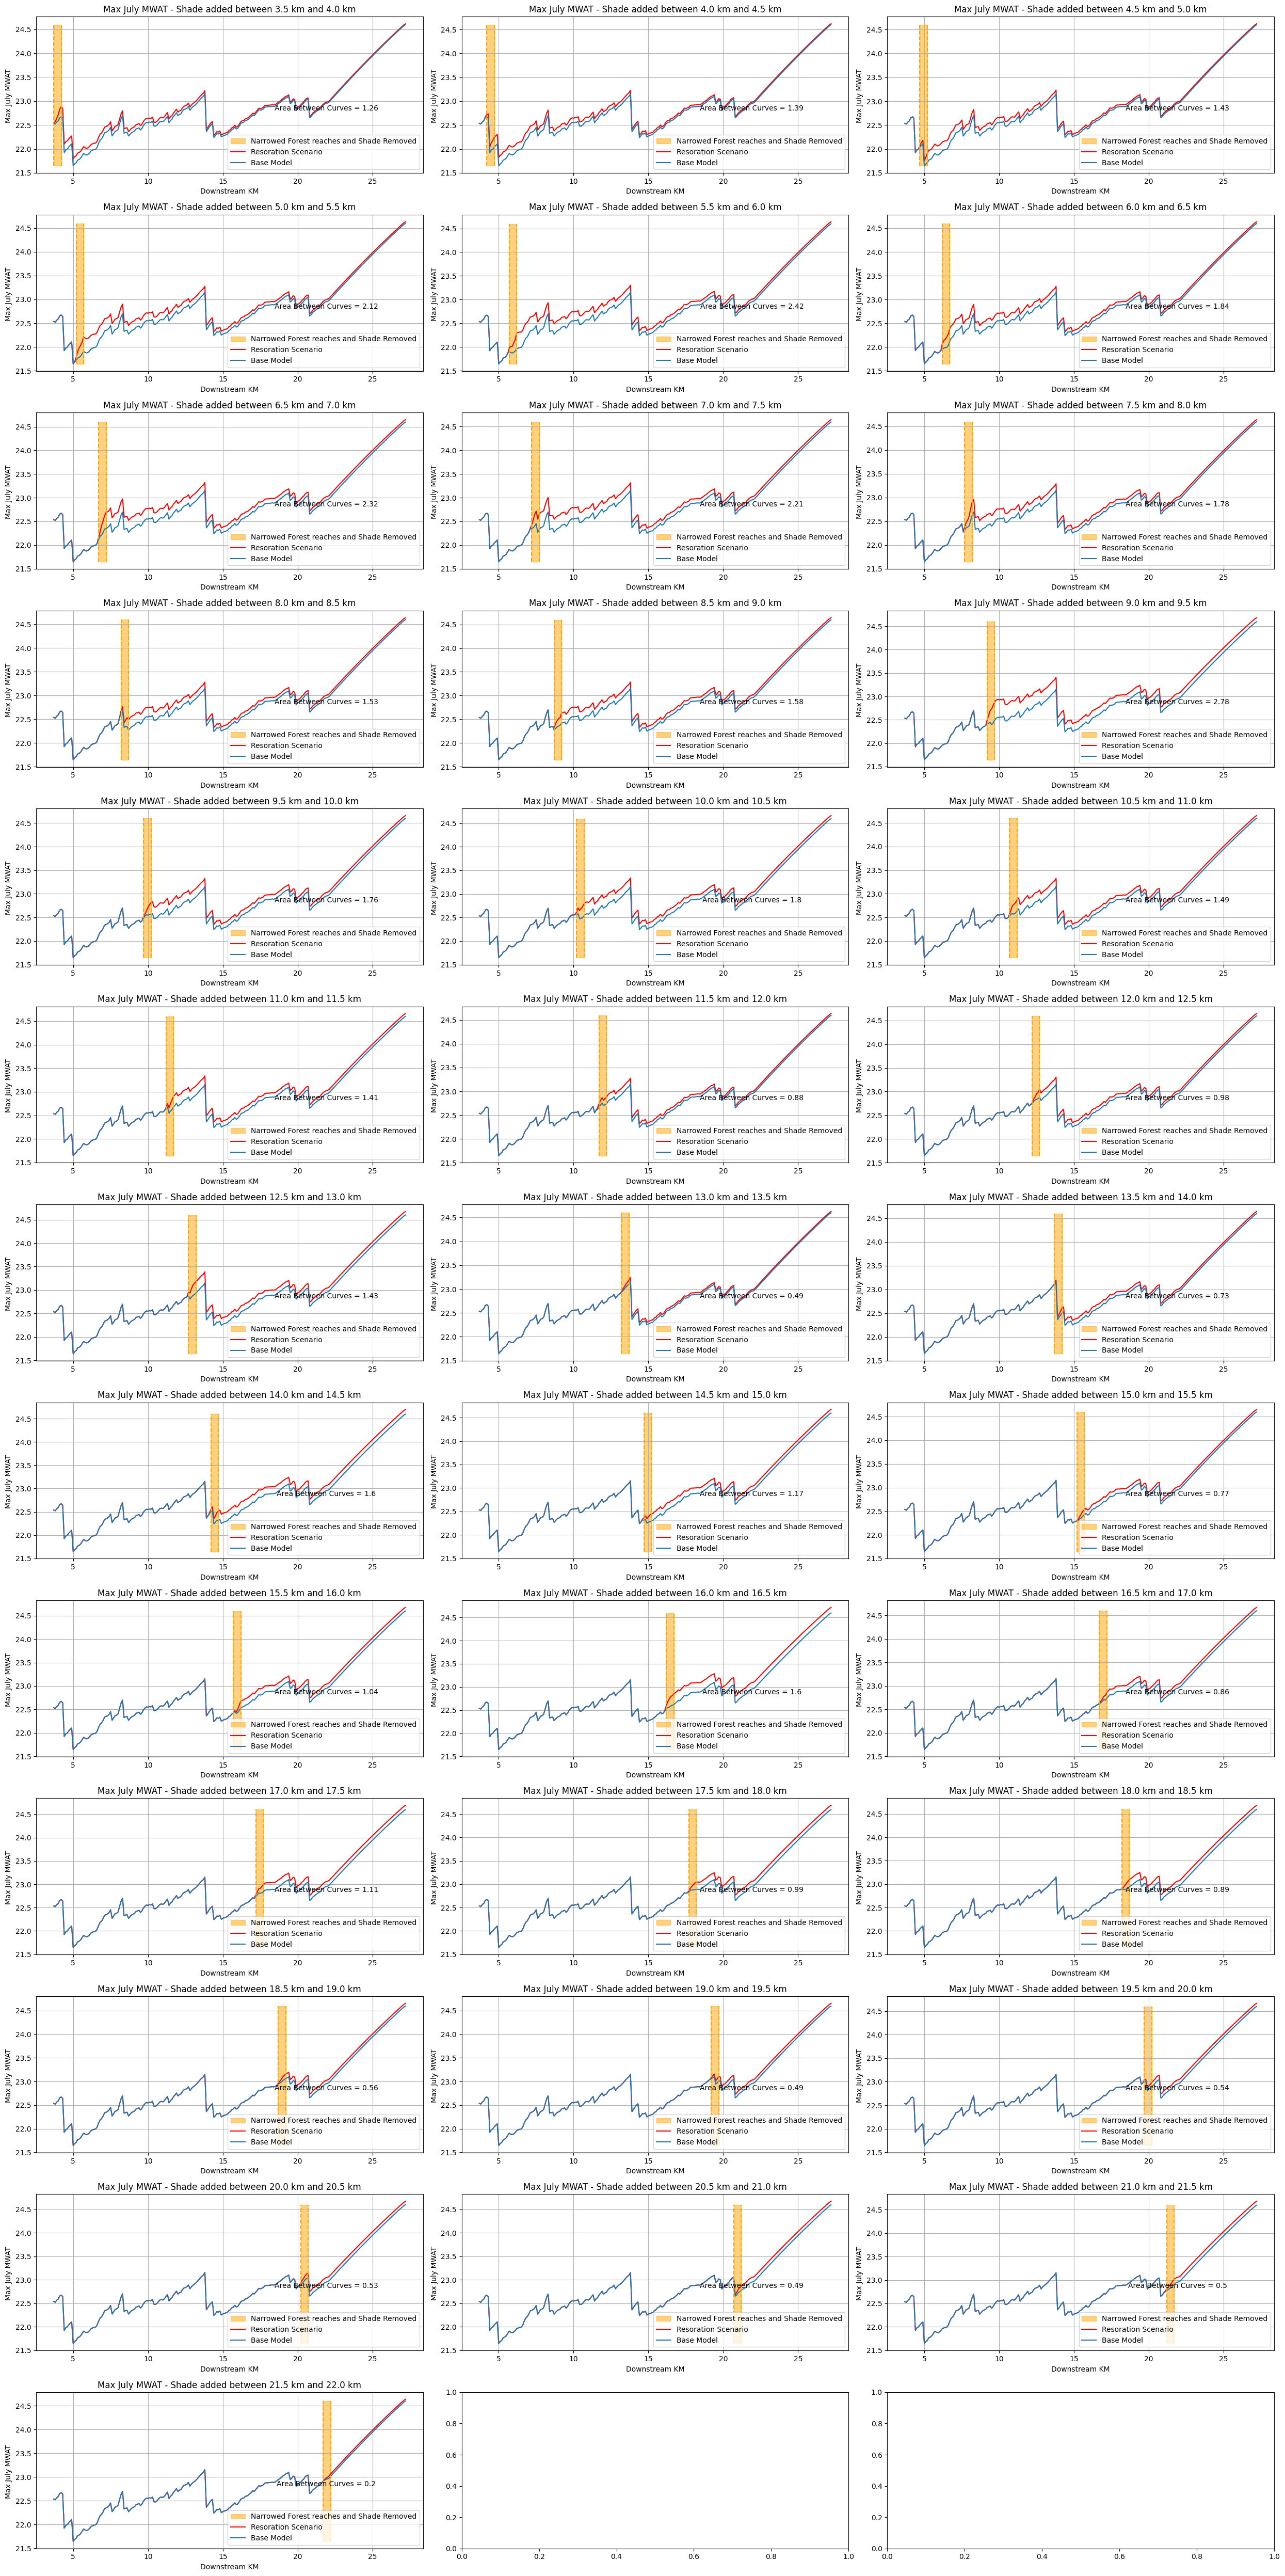

In [19]:
obs["datetime"] = pd.to_datetime(obs["datetime"])
obs_clip = obs[(obs["datetime"]>=cc_start) & (obs["datetime"]<cc_end + pd.DateOffset(1))]


obs_clip = obs_clip.dropna(axis=1)
obs_clip = obs_clip.set_index('datetime')
#obs_clip.columns = [float(col) for col in obs_clip.columns[2:]]
obs_clip.columns = [float(col) for col in obs_clip.columns]
obs_clip.drop(19.3, axis=1, inplace=True)
#plotting from bankbuffer
fig, axes = plt.subplots(13, 3, figsize=(25, 50))

    # Flatten the axes array to make it easier to iterate over
axes = axes.flatten()
hourly_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='H', inclusive='left') 
daily_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='D', inclusive='left') 
#upstreamconstant_df = 
upstreamconstant_df = pd.read_csv(os.path.join(base_source_folder, 'outputs', 'Temp_H2O.csv'), skiprows=6, usecols=range(1, 237))
upstreamconstant_df.columns = [float(col) for col in upstreamconstant_df.columns]
upstreamconstant_df.index = obs_clip.index
# mean july temperature summary
upstreamconstant_modeled_mean = upstreamconstant_df.resample('D').mean()

upstreamconstant_modeled = upstreamconstant_df.resample('D').mean()
# upstreamconstant_modeled = upstreamconstant_df.resample('D').sum()

upstreamconstant_modeled = upstreamconstant_modeled.mean()    
upstreamconstant_modeled = pd.DataFrame(upstreamconstant_modeled)
upstreamconstant_modeled = upstreamconstant_modeled.reset_index()
upstreamconstant_modeled.rename(columns={'index': 'NODE_ID', 0 : 'Mean July Temp'}, inplace=True)

obs_rolling_avg = upstreamconstant_modeled_mean.rolling(window=7).max()
obs_max_mwat = obs_rolling_avg.max()
upstreamconstant_modeled['Max MWAT'] = obs_max_mwat.values

#base shade scenario

base_shade_df = pd.read_csv(os.path.join(base_source_folder, 'outputs', 'Shade.csv'), skiprows=6, usecols=range(1, 237))
base_hourly_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='H', inclusive='left')  # Closed left ensures end date is exclusive
base_shade_df.columns = [float(col) for col in base_shade_df.columns]
base_shade_df.index = daily_index
# base_shade_df.index = obs_clip.index

base_shade = base_shade_df.mean()
base_shade = pd.DataFrame(base_shade)
base_shade = base_shade.reset_index()
base_shade.rename(columns={'index': 'NODE_ID', 0 : 'Effective Shade %'}, inplace=True)

#discts to hold differneces between scenarios
effectiveness_difference = {}
reach_shade_base = {}
reach_shade_scenario = {}
reach_shade_change = {}
reach_velocity = {}
reach_width = {}
reach_depth = {}
reach_widthdepth = {}
reach_azimuth = {}
reach_gradient = {}
reach_accretion = {}
count = 0
for i in values:
    count += 1
    km_start = i
    km_end = i-.5
    if km_start == 0:
        continue
    else:
        # km_start = i+1
        # km_end = i
        reach_source_folder = os.path.abspath(os.path.join(script_dir, 'scenarios','scenario_outputs', 'july_treeremoval', f'treeremoval{i}'))
        modeled_tw_df = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Temp_H2O.csv'), skiprows=6, usecols=range(1, 237))
        modeled_tw_df.columns = [float(col) for col in modeled_tw_df.columns]
        modeled_tw_df.index = obs_clip.index
        # mean july temperature summary
        mean_daily_modeled = modeled_tw_df.resample('D').mean()
        mean_july_modeled = mean_daily_modeled.mean()    
        mean_july_modeled = pd.DataFrame(mean_july_modeled)
        mean_july_modeled = mean_july_modeled.reset_index()
        mean_july_modeled.rename(columns={'index': 'NODE_ID', 0 : 'Mean July Temp'}, inplace=True)
        sim__rolling_avg = mean_daily_modeled.rolling(window=7).max()
        sim_max_mwat = sim__rolling_avg.max()
        mean_july_modeled['Max MWAT'] = sim_max_mwat.values
        # mwat = mean_daily_modeled.rolling(window=7).max()
        # mwat = mwat.max()
        # mwat = pd.DataFrame(mwat)
        # mean_july_modeled = pd.merge(mean_july_modeled, mwat[0], left_on='NODE_ID', right_index = True, how='left')
        # mean_july_modeled.rename(columns={0: 'Max MWAT'}, inplace=True) 
        
        #saving reach effectiveness
        # difference = mean_july_modeled['Mean July Temp'] - upstreamconstant_modeled['Mean July Temp']
        # norm_difference = difference/km_start
        # norm_difference = norm_difference.values.sum()
        # norm_effectiveness_difference[km_start] = norm_difference
        # effectiveness_difference[km_start] = difference.values.sum()
        
        #doing integration
        x = mean_july_modeled['NODE_ID']
        y1 = mean_july_modeled['Mean July Temp']
        y2 = upstreamconstant_modeled['Mean July Temp']

        
        
        
        
        # Compute absolute difference between the curves
        abs_diff = np.abs(y1 - y2)

        # Use Simpson's rule for numerical integration
        area = simps(abs_diff, x)
        area
        #changing sign of degree kilomters to be negative or positive based on if its cooling (negative) or warming (positive) from restoration
        if (upstreamconstant_modeled - mean_july_modeled ).mean()['Mean July Temp'] <= 0:
            area = area*-1
        
        effectiveness_difference[km_start] = area
        
        #getting effective shade values
        control_file = pd.read_csv(os.path.join(base_source_folder, 'HeatSource_Control.csv'))
        cc_start = control_file.loc[7]['VALUE']
        cc_start = pd.to_datetime(cc_start)
        cc_end = control_file.loc[8]['VALUE']
        cc_end = pd.to_datetime(cc_end)
        scenario_shade_df = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Shade.csv'), skiprows=6, usecols=range(1, 237))
        # hourly_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='D', inclusive='left')  # Closed left ensures end date is exclusive
        #         hourly_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='D', inclusive='left')  # Closed left ensures end date is exclusive

        scenario_shade_df.columns = [float(col) for col in scenario_shade_df.columns]
        scenario_shade_df.index = daily_index
        shade = scenario_shade_df.mean()
        shade = pd.DataFrame(shade)
        shade = shade.reset_index()
        shade.rename(columns={'index': 'NODE_ID', 0 : 'Effective Shade %'}, inplace=True)
        reach = shade[(shade['NODE_ID'] <= km_start) & (shade['NODE_ID'] >=km_end)]
        base_reach = base_shade[(base_shade['NODE_ID'] <= km_start) & (base_shade['NODE_ID'] >=km_end)]
        #compare base shade to scenario shade
        reach_percent_increase = (base_reach - reach)/base_reach
        #BECAUSE SR Increase should be positive
        reach_difference =  reach - base_reach
        reach_mean_percent_increase = reach_percent_increase['Effective Shade %'].mean()    
        #reach_shade[km_start] = reach_mean_percent_increase
        reach_shade_base[km_start] = base_reach['Effective Shade %'].mean()
        reach_shade_scenario[km_start] = reach['Effective Shade %'].mean()
        reach_shade_change[km_start] = reach_difference['Effective Shade %'].mean()

        #get reach azimuth
        azimuth = pd.read_csv(os.path.abspath(os.path.join(script_dir, 'scenarios','stream_azimuth.csv')))
        azimuth_reach = azimuth[(azimuth['STREAM_KM'] <= km_start) & (azimuth['STREAM_KM'] >=km_end)]
        azimuth_reach_mean = azimuth_reach['Azm'].mean()
        reach_azimuth[km_start] = abs(azimuth_reach_mean-180)
        
        #get reach gradient 
        gradient = pd.read_csv(os.path.abspath(os.path.join(script_dir, 'scenarios','stream_azimuth.csv')))
        gradient_reach = gradient[(gradient['STREAM_KM'] <= km_start) & (gradient['STREAM_KM'] >=km_end)]
        gradient_reach_mean = gradient_reach['GRADIENT'].mean()
        reach_gradient[km_start] = gradient_reach_mean

        #getting mean velocity
        velocity = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Hyd_Vel.csv'), skiprows=6, usecols=range(1, 237))
        velocity.columns = [float(col) for col in velocity.columns]
        sim_velocity = velocity.mean()#.to_numpy()
        sim_velocity = pd.DataFrame(sim_velocity)
        sim_velocity = sim_velocity.reset_index()
        sim_velocity.rename(columns={'index': 'NODE_ID', 0 : 'Velocity'}, inplace=True)
        velocity_reach = sim_velocity[(sim_velocity['NODE_ID'] <= km_start) & (sim_velocity['NODE_ID'] >=km_end)]
        reach_mean_velocity = velocity_reach['Velocity'].mean()
        reach_velocity[km_start] = reach_mean_velocity
        
        #Getting Width
        sim_width = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Hyd_WT.csv'), skiprows=6, usecols=range(1, 237))
        sim_width.columns = [float(col) for col in sim_width.columns]
        sim_width = sim_width.iloc[0]#.to_numpy()
        sim_width = pd.DataFrame(sim_width)
        sim_width = sim_width.reset_index()
        sim_width.rename(columns={'index': 'NODE_ID', 0 : 'Width'}, inplace=True)
        sim_width = sim_width[(sim_width['NODE_ID'] <= km_start) & (sim_width['NODE_ID'] >=km_end)]
        reach_width[km_start] = sim_width['Width'].mean()
        
        #getting depth
        sim_depth = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Hyd_DA.csv'), skiprows=6, usecols=range(1, 237))
        sim_depth.columns = [float(col) for col in sim_depth.columns]
        sim_depth = sim_depth.iloc[0]#.to_numpy()
        sim_depth = pd.DataFrame(sim_depth)
        sim_depth = sim_depth.reset_index()
        sim_depth.rename(columns={'index': 'NODE_ID', 0 : f'Depth'}, inplace=True)
        sim_depth = sim_depth[(sim_depth['NODE_ID'] <= km_start) & (sim_depth['NODE_ID'] >=km_end)]
        reach_depth[km_start] = sim_depth['Depth'].mean()
        #width:depth
        reach_widthdepth[km_start] = (sim_width['Width'].mean()/sim_depth['Depth'].mean())
        

        #get reach accretion
        sim_discharge = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Hyd_Flow.csv'), skiprows=6, usecols=range(1, 237)) 
        sim_discharge.columns = [float(col) for col in sim_discharge.columns]
        sim_discharge = sim_discharge.iloc[0]#.to_numpy()
        sim_discharge = pd.DataFrame(sim_discharge)
        sim_discharge = sim_discharge.reset_index()
        sim_discharge.rename(columns={'index': 'NODE_ID', 0 : f'Discharge'}, inplace=True)
        sim_discharge = sim_discharge[(sim_discharge['NODE_ID'] <= km_start) & (sim_discharge['NODE_ID'] >= km_end)]
        reach_accretion[km_start] =   sim_discharge.iloc[-1]['Discharge'] - sim_discharge.iloc[0]['Discharge']

        #plotting
        # Create a new figure with a 3x3 grid of subplots

        shade_start = i
        #plt.figure()  # Create a new figure for each iteration  
        axes[count-1].fill_between([27.2 - km_start, 27.2 - km_end], upstreamconstant_modeled['Max MWAT'].min(),upstreamconstant_modeled['Max MWAT'].max(), color='orange', alpha = .5, label = 'Narrowed Forest reaches and Shade Removed')
        axes[count-1].plot(27.2-mean_july_modeled['NODE_ID'], mean_july_modeled['Max MWAT'], label=f'Resoration Scenario', color = 'red')
        axes[count-1].plot(27.2-upstreamconstant_modeled['NODE_ID'], upstreamconstant_modeled['Max MWAT'], label='Base Model')
        axes[count-1].set_title(f'Max July MWAT - Shade added between {27 - km_start} km and {27 - km_end} km')
        axes[count-1].set_xlabel('Downstream KM')  # Replace 'X Label' with appropriate label
        axes[count-1].set_ylabel('Max July MWAT ')  # Replace 'Y Label' with appropriate label
        axes[count-1].text(0.75, 0.4, f'Area Between Curves = {round(area,2)}', horizontalalignment='center', transform=axes[count-1].transAxes)

        # Plot the shade data on the second y-axis
        # axes[count-1] = axes[count-1].twinx()
        # axes[count-1].plot(27.2-shade.index, shade[0], label='Mean Solar Radiation Flux \n At Stream Surface', color='red', alpha = .5)
        # axes[count-1].set_ylabel('Mean Solar Radiation Flux \n At Stream Surface (W/m2)', color = 'red')
        # axes[count-1].tick_params(axis='y', colors='red')

        axes[count-1].vlines([27.2 - km_start, 27.2 - km_end], ymin = upstreamconstant_modeled['Max MWAT'].min(), ymax = upstreamconstant_modeled['Max MWAT'].max(),color = 'orange', linestyles = 'dashed')
        axes[count-1].grid(True) 
        axes[count-1].legend(loc = 'lower right')

        #axes[count-1].legend(loc = 'lower right')
        # axes[count-1].set_xlim([18.3 - km_end-2, 18.3 - km_start+2 ])


    #plt.show()
    #add vertical line where shade is added              
plt.tight_layout()
fig.patch.set_facecolor('white')

#plt.savefig(r'D:/Ben_wd/THESIS/heatsource/WestFork/ModelRuns/Hayes/scenarios/thesis_scenarios/500m_run/narrow/reach_shaderemoval+narrow20.png')
plt.show()
#new_folder_name = f"folder_{km_start}"

In [98]:
 #get reach discharge
test = {}
km_start = 27
km_end = 26.5
sim_discharge = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Hyd_Flow.csv'), skiprows=6, usecols=range(1, 274)) 
sim_discharge.columns = [float(col) for col in sim_discharge.columns]
sim_discharge = sim_discharge.iloc[0]#.to_numpy()
sim_discharge = pd.DataFrame(sim_discharge)
sim_discharge = sim_discharge.reset_index()
sim_discharge.rename(columns={'index': 'NODE_ID', 0 : f'Discharge'}, inplace=True)
sim_discharge = sim_discharge[(sim_discharge['NODE_ID'] <= 10.0) & (sim_discharge['NODE_ID'] >= 9.5)]
test[km_start] =  sim_discharge.iloc[-1]['Discharge'] - sim_discharge.iloc[0]['Discharge']
test

{27: 0.0021999999999999797}

In [21]:
#read in 500m reaches shapefile
nodes = gpd.read_file(os.path.abspath(os.path.join(script_dir, 'shp', 'centerline_500msplit.shp')))
nodes

reach_shadescenario_dict = pd.DataFrame(list(reach_shade_scenario.items()), columns=['Reach Start KM', 'SR Scenario'])
reach_shadebase_dict = pd.DataFrame(list(reach_shade_base.items()), columns=['Reach Start KM', 'SR Baseline'])
reach_velocity_dict = pd.DataFrame(list(reach_velocity.items()), columns=['Reach Start KM', 'Velocity'])
reach_width_dict = pd.DataFrame(list(reach_width.items()), columns=['Reach Start KM', 'Width'])
reach_depth_dict = pd.DataFrame(list(reach_depth.items()), columns=['Reach Start KM', 'Depth'])
reach_widthdepth_dict = pd.DataFrame(list(reach_widthdepth.items()), columns=['Reach Start KM', 'Width:Depth'])
reach_shadedif_dict = pd.DataFrame(list(reach_shade_change.items()), columns=['Reach Start KM', 'SR Difference'])
reach_azimuth_dict = pd.DataFrame(list(reach_azimuth.items()), columns=['Reach Start KM', 'Mean Azimuth'])
reach_gradient_dict = pd.DataFrame(list(reach_gradient.items()), columns=['Reach Start KM', 'Gradient'])
reach_accretion_dict = pd.DataFrame(list(reach_accretion.items()), columns=['Reach Start KM', 'Accretion'])



#creating df to add to 
dif_df_dict = pd.DataFrame(list(effectiveness_difference.items()), columns=['Reach Start KM', 'Degree Kilometers'])

#adding data from scenarios
dif_df_dict['Model Start KM'] = dif_df_dict['Reach Start KM']
dif_df_dict['Reach Start KM'] = dif_df_dict['Reach Start KM']-9
dif_df_dict['Mean velocity'] = reach_velocity_dict['Velocity']
dif_df_dict['Mean Azimuth'] = reach_azimuth_dict['Mean Azimuth']
dif_df_dict['Width'] = reach_width_dict['Width']
dif_df_dict['Depth'] = reach_depth_dict['Depth']
dif_df_dict['Width:Depth'] = reach_widthdepth_dict['Width:Depth']
dif_df_dict['Change in SR'] = reach_shadedif_dict['SR Difference']*100
dif_df_dict['Baseline SR'] = reach_shadebase_dict['SR Baseline']*100
dif_df_dict['Scenario SR'] = reach_shadescenario_dict['SR Scenario']*100
dif_df_dict['absolute DK'] = abs(dif_df_dict['Degree Kilometers'])
dif_df_dict['Gradient'] = reach_gradient_dict['Gradient']
dif_df_dict['Accretion'] = reach_accretion_dict['Accretion']

dif_df_dict['reach2'] = dif_df_dict.index


dif_df_dict.drop(dif_df_dict.tail(1).index, inplace=True)
dif_df_dict['Distance Downstream'] = 18.0 - dif_df_dict['Reach Start KM']
dif_df_dict = dif_df_dict.sort_values('Degree Kilometers')
dif_df_dict.reset_index(drop=True, inplace=True)
dif_df_dict.index.name = 'Effectiveness Rank'
dif_df_dict.reset_index(inplace=True)
dif_df_dict.index += 1
merged_gdf_dif = pd.merge(nodes, dif_df_dict[['Reach Start KM','Degree Kilometers', 'reach2','absolute DK','Effectiveness Rank', 'Width', 'Baseline SR', 'Change in SR', 'Mean velocity']], left_on='reach2', right_on = 'reach2', how='left')
#merged_gdf_dif.drop(merged_gdf_dif['row'], axis=0, errors='ignore')

#merged_gdf_dif.to_file(r'D:/Ben_wd/THESIS/heatsource/WestFork/ModelRuns/Hayes/scenarios/thesis_scenarios/extending_model/ranking_treeremoval.shp')
dif_df_dict.sort_values(by = 'Effectiveness Rank')

Effectiveness Rank  Reach Start KM  Degree Kilometers  Model Start KM  \
1                    0             5.0           0.488097            14.0   
2                    1            -1.0           0.493428             8.0   
3                    2            -2.5           0.494095             6.5   
4                    3            -3.0           0.499863             6.0   
5                    4            -2.0           0.527764             7.0   
6                    5            -1.5           0.539550             7.5   
7                    6            -0.5           0.564108             8.5   
8                    7             4.5           0.730057            13.5   
9                    8             3.0           0.771032            12.0   
10                   9             1.5           0.856618            10.5   
11                  10             6.5           0.875345            15.5   
12                  11             0.0           0.886862             9.0   
13                  12             6.0           0.980791            15.0   
14                  13             0.5           0.988570             9.5   
15                  14             2.5           1.035074            11.5   
16                  15             1.0           1.114344            10.0   
17                  16             3.5           1.166701            12.5   
18                  17            14.5           1.261479            23.5   
19                  18            14.0           1.394340            23.0   
20                  19             7.0           1.413005            16.0   
21                  20            13.5           1.427377            22.5   
22                  21             5.5           1.434805            14.5   
23                  22             7.5           1.493999            16.5   
24                  23            10.0           1.529607            19.0   
25                  24             9.5           1.581460            18.5   
26                  25             2.0           1.599162            11.0   
27                  26             4.0           1.601215            13.0   
28                  27             8.5           1.755324            17.5   
29                  28            10.5           1.776367            19.5   
30                  29             8.0           1.802603            17.0   
31                  30            12.0           1.837008            21.0   
32                  31            13.0           2.117050            22.0   
33                  32            11.0           2.206016            20.0   
34                  33            11.5           2.315469            20.5   
35                  34            12.5           2.416596            21.5   
36                  35             9.0           2.775675            18.0   

    Mean velocity  Mean Azimuth      Width     Depth  Width:Depth  \
1        0.418177      8.659447   8.490600  0.198733    42.723583   
2        0.350018      7.455045  14.544617  0.229633    63.338438   
3        0.151521     63.526866  16.551667  0.514583    32.165182   
4        0.297405     70.598715  15.252383  0.269567    56.581118   
5        0.264142     72.205121  15.943750  0.379550    42.006982   
6        0.444998     17.093800  18.937000  0.134150   141.162877   
7        0.204215     40.345869  12.545183  0.494450    25.371996   
8        0.248559     18.037621  15.006250  0.217833    68.888676   
9        0.266697     15.991175  11.754917  0.365867    32.128963   
10       0.197393     68.520392  14.785617  0.347600    42.536297   
11       0.422305     32.713317  13.006600  0.124333   104.610724   
12       0.243731     13.065240  12.549850  0.359333    34.925371   
13       0.292294     22.173170  13.511200  0.158283    85.360851   
14       0.195477     26.163196  12.138433  0.415417    29.219900   
15       0.175777      2.209810  16.323000  0.419700    38.892066   
16       0.161066     68.031051  15.559733  0.3853

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


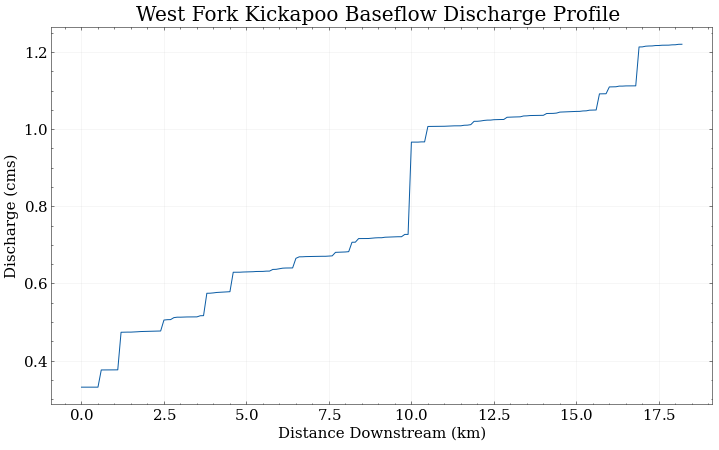

In [38]:
import scienceplots

sim_discharge = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Hyd_Flow.csv'), skiprows=6, usecols=range(1, 274)) 
sim_discharge.columns = [float(col) for col in sim_discharge.columns]
sim_discharge = sim_discharge.iloc[0]#.to_numpy()
sim_discharge = pd.DataFrame(sim_discharge)
sim_discharge = sim_discharge.reset_index()
sim_discharge.rename(columns={'index': 'NODE_ID', 0 : f'Discharge'}, inplace=True)
discharge_slice = sim_discharge.iloc[:183]
with plt.style.context(['science', 'no-latex']):
    # Plotting original and smoothed data
    plt.figure(figsize=(10, 6))
    plt.plot(27.2 - discharge_slice['NODE_ID'], discharge_slice['Discharge'])
    plt.ylabel('Discharge (cms)', size = 15)
    plt.xlabel('Distance Downstream', size = 15)
    #plt.figure(facecolor='black')

        # Adjust layout
    plt.tight_layout()
    plt.grid(alpha = .2)
    plt.yticks(size= 15)
    plt.xticks(size= 15)
    plt.xlabel('Distance Downstream (km)')
    #plt.vlines(trib_dict_downstream, ymin = 20, ymax = 25, label = 'Tribs',color = 'Orange', linestyles = 'dashed')
    plt.legend(loc = 'upper right', fontsize = 12)
    plt.title('West Fork Kickapoo Baseflow Discharge Profile ', size = 20)
    plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\Discharge_profile.png', bbox_inches='tight', dpi=300)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


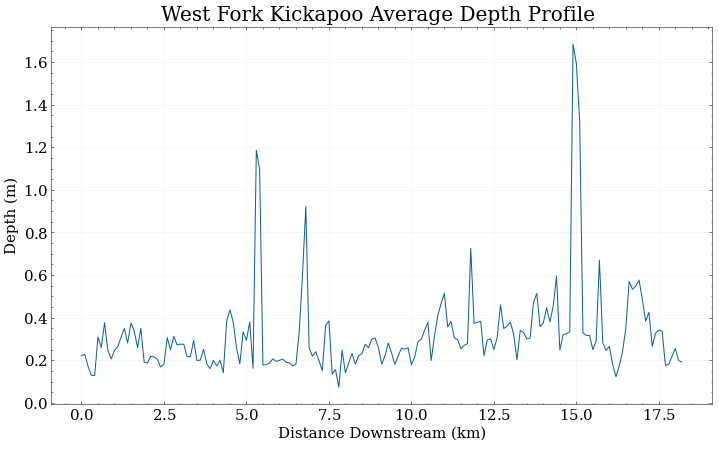

In [48]:
import scienceplots

sim_discharge = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Hyd_DM.csv'), skiprows=6, usecols=range(1, 274)) 
sim_discharge.columns = [float(col) for col in sim_discharge.columns]
sim_discharge = sim_discharge.iloc[0]#.to_numpy()
sim_discharge = pd.DataFrame(sim_discharge)
sim_discharge = sim_discharge.reset_index()
sim_discharge.rename(columns={'index': 'NODE_ID', 0 : f'Discharge'}, inplace=True)
discharge_slice = sim_discharge.iloc[:183]
with plt.style.context(['science', 'no-latex']):
    # Plotting original and smoothed data
    plt.figure(figsize=(10, 6))
    plt.plot(27.2 - discharge_slice['NODE_ID'], discharge_slice['Discharge'])
    plt.ylabel('Depth (m)', size = 15)
    plt.xlabel('Distance Downstream', size = 15)
    #plt.figure(facecolor='black')

        # Adjust layout
    plt.tight_layout()
    plt.grid(alpha = .2)
    plt.yticks(size= 15)
    plt.xticks(size= 15)
    plt.xlabel('Distance Downstream (km)')
    #plt.vlines(trib_dict_downstream, ymin = 20, ymax = 25, label = 'Tribs',color = 'Orange', linestyles = 'dashed')
    plt.legend(loc = 'upper right', fontsize = 12)
    plt.title('West Fork Kickapoo Average Depth Profile ', size = 20)
    plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\Depth_profile.png', bbox_inches='tight', dpi=300)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


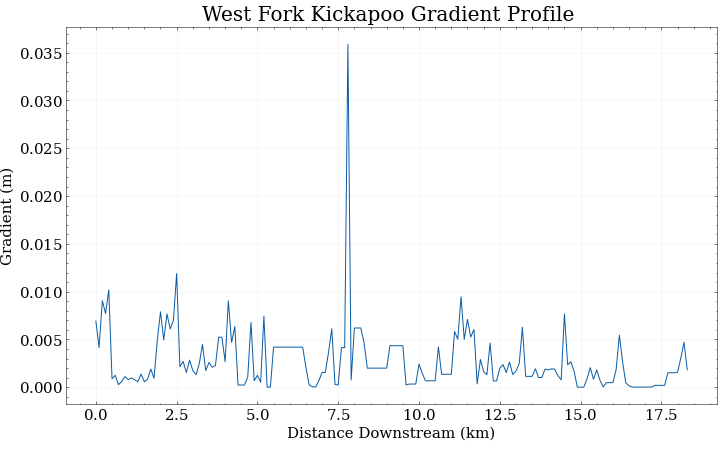

In [46]:
gradient = pd.read_csv('Channel_azimuth.csv')
gradient
with plt.style.context(['science', 'no-latex']):
    # Plotting original and smoothed data
    plt.figure(figsize=(10, 6))
    plt.plot(27.2 - gradient['STREAM_KM'], gradient['GRADIENT'])
    plt.ylabel('Gradient (m)', size = 15)
    plt.xlabel('Distance Downstream', size = 15)
    #plt.figure(facecolor='black')

        # Adjust layout
    plt.tight_layout()
    plt.grid(alpha = .2)
    plt.yticks(size= 15)
    plt.xticks(size= 15)
    plt.xlabel('Distance Downstream (km)')
    #plt.vlines(trib_dict_downstream, ymin = 20, ymax = 25, label = 'Tribs',color = 'Orange', linestyles = 'dashed')
    plt.legend(loc = 'upper right', fontsize = 12)
    plt.title('West Fork Kickapoo Gradient Profile ', size = 20)
    plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\Gradient_profile.png', bbox_inches='tight', dpi=300)


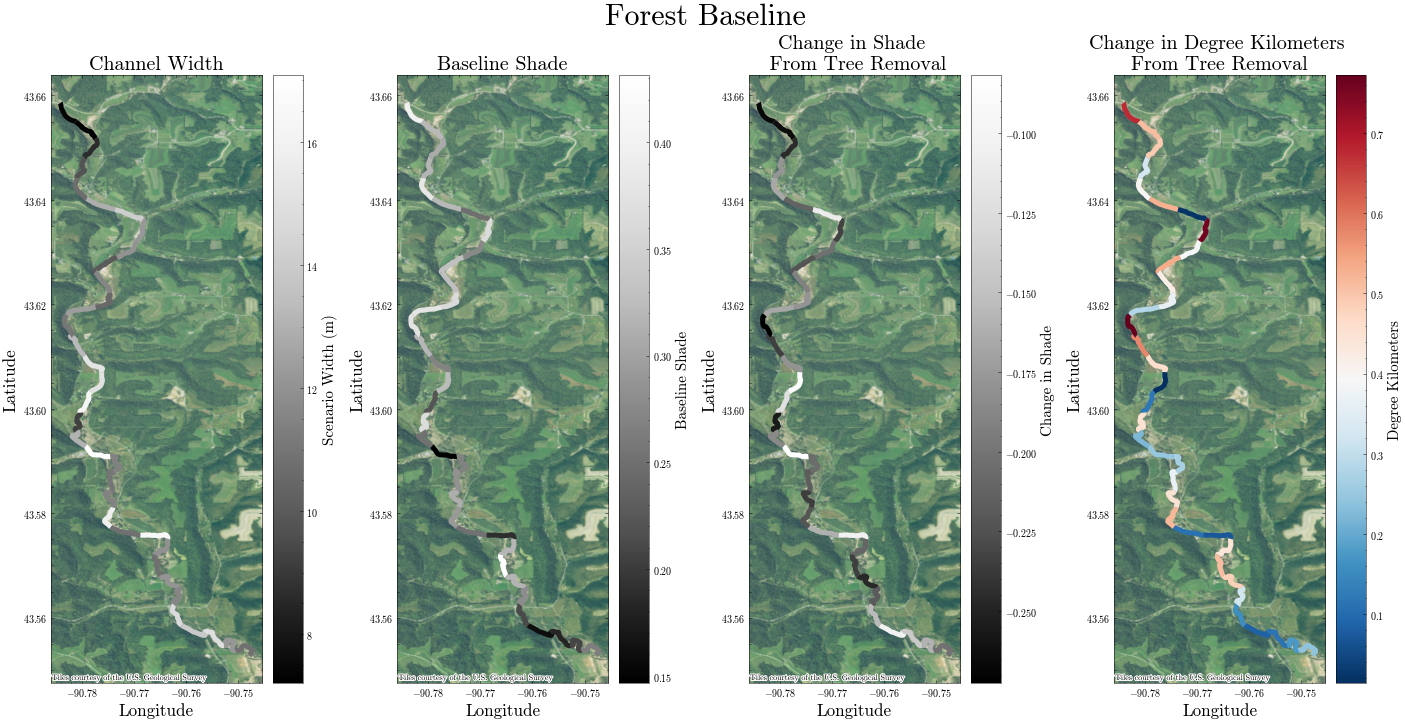

In [29]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import contextily as ctx
import scienceplots


# Define the original colormap
original_cmap = plt.cm.Greys
degree_cmap = plt.cm.RdBu
inverted_degree_cmap = degree_cmap.reversed()

# Invert the colormap
inverted_cmap = original_cmap.reversed()

# Define the boundaries for the colorbar steps
bounds_width = [merged_gdf_dif['Width'].min(), merged_gdf_dif['Width'].max()]  
bounds_dif = [merged_gdf_dif['Baseline SR'].min(), merged_gdf_dif['Baseline SR'].max()]
bounds_changeSR = [merged_gdf_dif['Change in SR'].min(), merged_gdf_dif['Change in SR'].max()]

# Create a colormap norm with the defined boundaries
norm1 = mcolors.Normalize(vmin=merged_gdf_dif['Width'].min(), vmax=merged_gdf_dif['Width'].max())
norm2 = mcolors.Normalize(vmin=merged_gdf_dif['Baseline SR'].min(), vmax=merged_gdf_dif['Baseline SR'].max())
norm3 = mcolors.Normalize(vmin=merged_gdf_dif['Change in SR'].min(), vmax=merged_gdf_dif['Change in SR'].max())
#absolute value of degree kilomtere cuz its warming
norm4 = mcolors.Normalize(vmin=merged_gdf_dif['absolute DK'].min(), vmax=merged_gdf_dif['absolute DK'].max())

with plt.style.context(['science', 'no-latex']):
    # plotting the difference in temps between modeled reaches, with ranking
    fig, axes = plt.subplots(1, 4, figsize=(20, 10), layout = 'compressed')
    fig.suptitle('Forest Baseline', fontsize=30)

    db_lonlat = merged_gdf_dif.to_crs(epsg=4326)
    #ctx.add_basemap(axes[0], crs=db_lonlat.crs)
    
    # Plot the first map
    ax1 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Width', cmap=inverted_cmap, linewidth=5, ax=axes[0], norm=norm1)
    ctx.add_basemap(ax1, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax1.set_xlabel('Longitude', fontsize=17)
    ax1.set_ylabel('Latitude', fontsize=17)
    ax1.set_title('Channel Width', fontsize=20)

    # Plot the second map
    ax2 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Baseline SR', cmap=inverted_cmap, linewidth=5, ax=axes[1], norm=norm2)
    ctx.add_basemap(ax2, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax2.set_title('Baseline Shade', fontsize=20)
    ax2.set_xlabel('Longitude', fontsize=17)
    ax2.set_ylabel('Latitude', fontsize=17)
    
    ax3 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Change in SR', cmap=inverted_cmap, linewidth=5, ax=axes[2], norm=norm3)
    ctx.add_basemap(ax3, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax3.set_title('Change in Shade \n From Tree Removal', fontsize=20)
    ax3.set_xlabel('Longitude', fontsize=17)
    ax3.set_ylabel('Latitude', fontsize=17)
    
    ax4 = merged_gdf_dif.to_crs(epsg=4326).plot(column='absolute DK', cmap=inverted_degree_cmap, linewidth=5, ax=axes[3], norm=norm4)
    ctx.add_basemap(ax4, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax4.set_title('Change in Degree Kilometers \nFrom Tree Removal', fontsize=20)
    ax4.set_xlabel('Longitude', fontsize=17)
    ax4.set_ylabel('Latitude', fontsize=17)
    
    # Add colorbars for clarity
    cbar1 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm1, cmap=inverted_cmap), ax=axes[0], orientation='vertical')
    cbar1.set_label('Scenario Width (m)', fontsize=15)

    cbar2 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm2, cmap=inverted_cmap), ax=axes[1], orientation='vertical')
    cbar2.set_label('Baseline Shade', fontsize=15)
    
    cbar3 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm3, cmap=inverted_cmap), ax=axes[2], orientation='vertical')
    cbar3.set_label('Change in Shade', fontsize=15)
    
    cbar4 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm4, cmap=inverted_degree_cmap), ax=axes[3], orientation='vertical')
    cbar4.set_label('Degree Kilometers', fontsize=15)
    
    #plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\500mTreeRemovalEffectiveness.png', bbox_inches='tight', dpi=300)
    plt.show()


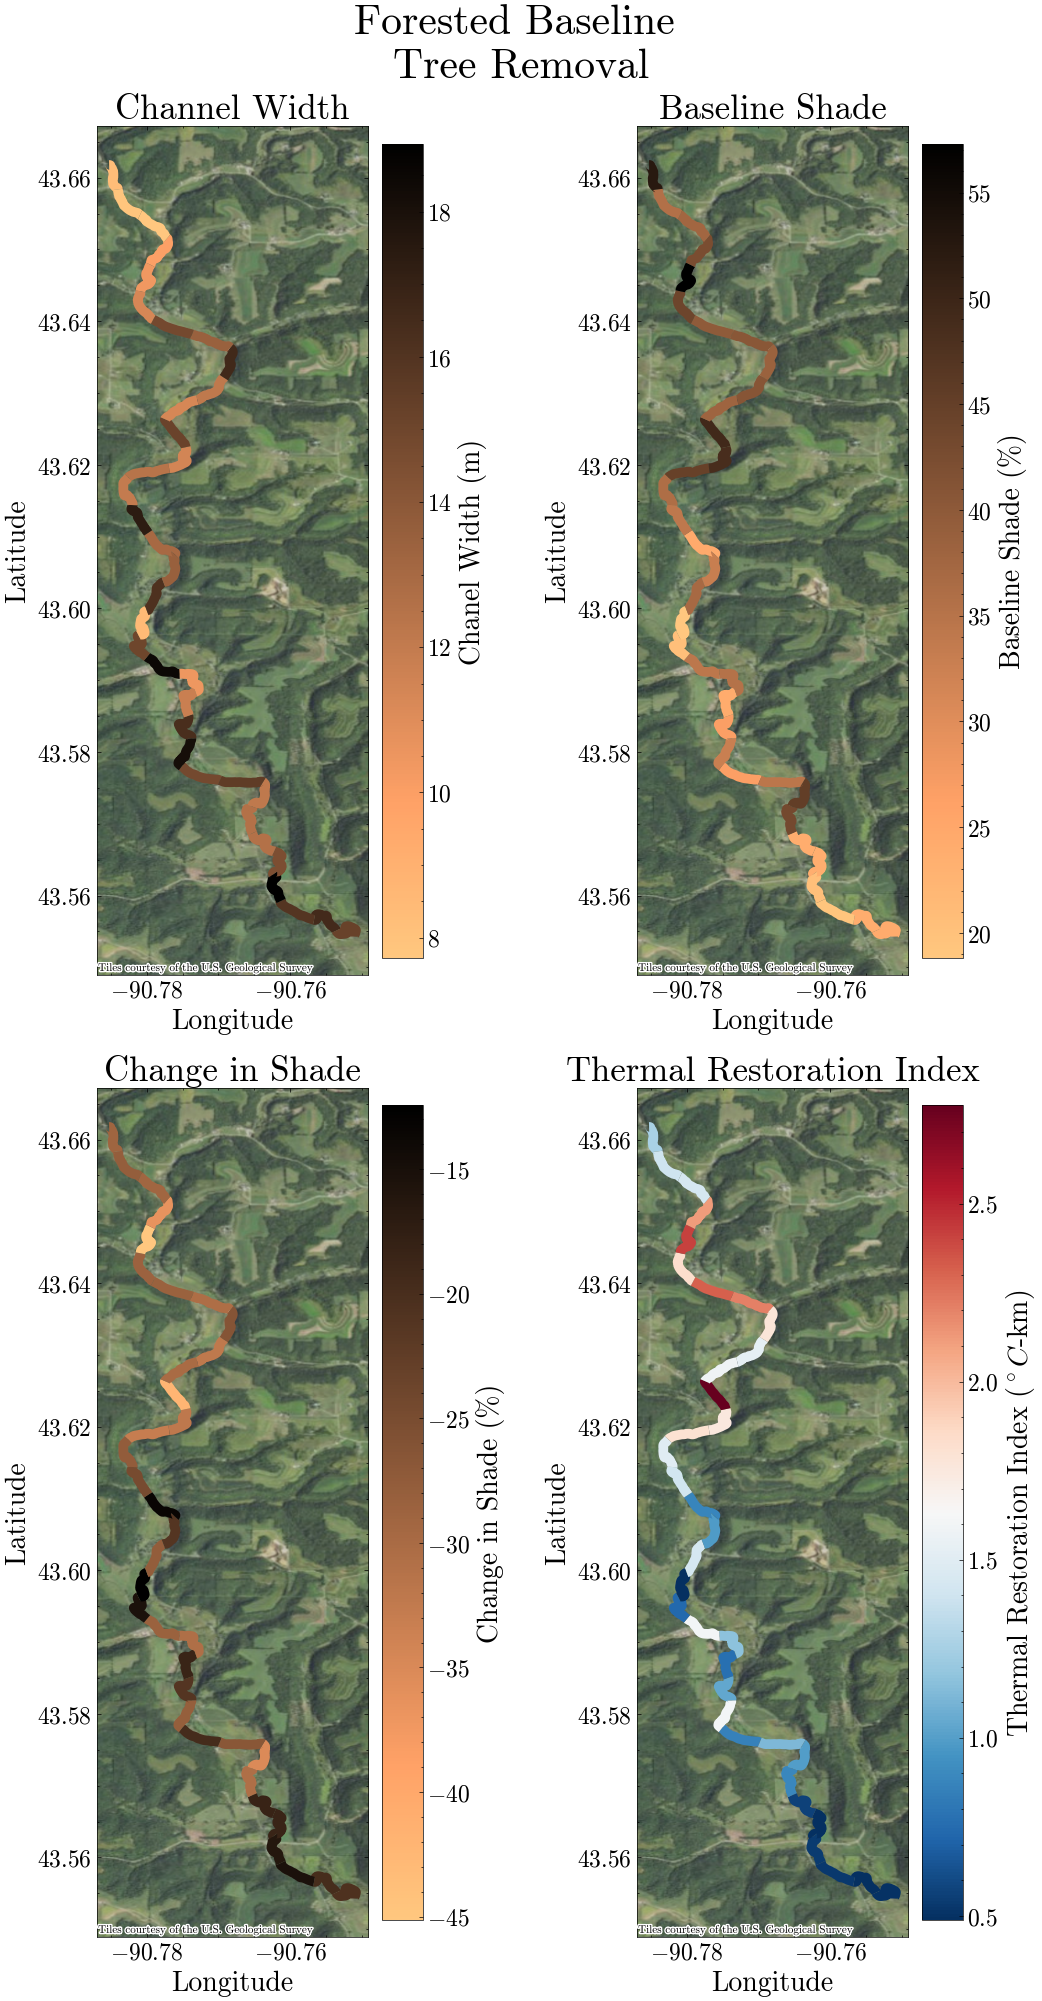

In [26]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import contextily as ctx
import scienceplots


# Define the original colormap
original_cmap = plt.cm.copper
degree_cmap = plt.cm.RdBu
inverted_degree_cmap = degree_cmap.reversed()

# Invert the colormap
inverted_cmap = original_cmap.reversed()

# Define the boundaries for the colorbar steps
bounds_width = [merged_gdf_dif['Width'].min(), merged_gdf_dif['Width'].max()]  
bounds_dif = [merged_gdf_dif['Baseline SR'].min(), merged_gdf_dif['Baseline SR'].max()]
bounds_changeSR = [merged_gdf_dif['Change in SR'].min(), merged_gdf_dif['Change in SR'].max()]

# Create a colormap norm with the defined boundaries
norm1 = mcolors.Normalize(vmin=merged_gdf_dif['Width'].min(), vmax=merged_gdf_dif['Width'].max())
norm2 = mcolors.Normalize(vmin=merged_gdf_dif['Baseline SR'].min(), vmax=merged_gdf_dif['Baseline SR'].max())
norm3 = mcolors.Normalize(vmin=merged_gdf_dif['Change in SR'].min(), vmax=merged_gdf_dif['Change in SR'].max())
norm4 = mcolors.Normalize(vmin=merged_gdf_dif['Degree Kilometers'].min(), vmax=merged_gdf_dif['Degree Kilometers'].max())

with plt.style.context(['science', 'no-latex']):
    # plotting the difference in temps between modeled reaches, with ranking
    fig, axes = plt.subplots(2, 2, figsize=(40, 20), layout = 'compressed')
    fig.suptitle('Forested Baseline \nTree Removal', fontsize=30)

    db_lonlat = merged_gdf_dif.to_crs(epsg=4326)
    #ctx.add_basemap(axes[0], crs=db_lonlat.crs)
    
    # Plot the first map
    ax1 = axes.flat[0]

    #ax1 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Width', cmap=inverted_cmap, linewidth=5, ax=axes[0], norm=norm1)
    merged_gdf_dif.to_crs(epsg=4326).plot(column='Width', cmap=inverted_cmap, linewidth=7, ax=ax1, norm=norm1)

    ctx.add_basemap(ax1, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax1.set_xlabel('Longitude', fontsize = 20)
    ax1.set_ylabel('Latitude', fontsize=20)
    ax1.set_title('Channel Width', fontsize=25)
    ax1.tick_params(axis='both', which='major', labelsize=17)

    # Plot the second map
    ax2 = axes.flat[1]

    # ax2 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Baseline SR', cmap=inverted_cmap, linewidth=5, ax=axes[1], norm=norm2)
    merged_gdf_dif.to_crs(epsg=4326).plot(column='Baseline SR', cmap=inverted_cmap, linewidth=7, ax=ax2, norm=norm2)

    ctx.add_basemap(ax2, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax2.set_title('Baseline Shade', fontsize=25)
    ax2.set_xlabel('Longitude', fontsize=20)
    ax2.set_ylabel('Latitude', fontsize=20)
    ax2.tick_params(axis='both', which='major', labelsize=17)

    
    ax3 = axes.flat[2]

    # ax3 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Change in SR', cmap=inverted_cmap, linewidth=5, ax=axes[2], norm=norm3)
    merged_gdf_dif.to_crs(epsg=4326).plot(column='Change in SR', cmap=inverted_cmap, linewidth=7, ax=ax3, norm=norm3)

    ctx.add_basemap(ax3, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax3.set_title('Change in Shade', fontsize=25)
    ax3.set_xlabel('Longitude', fontsize=20)
    ax3.set_ylabel('Latitude', fontsize=20)
    ax3.tick_params(axis='both', which='major', labelsize=17)

    ax4 = axes.flat[3]

    # ax4 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Degree Kilometers', cmap=inverted_degree_cmap, linewidth=5, ax=axes[3], norm=norm4)
    merged_gdf_dif.to_crs(epsg=4326).plot(column='Degree Kilometers', cmap=inverted_degree_cmap, linewidth=7, ax=ax4, norm=norm4)

    ctx.add_basemap(ax4, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax4.set_title('Thermal Restoration Index', fontsize=25)
    ax4.set_xlabel('Longitude', fontsize=20)
    ax4.set_ylabel('Latitude', fontsize=20)
    ax4.tick_params(axis='both', which='major', labelsize=17)

    # Add colorbars for clarity
    # cbar1 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm1, cmap=inverted_cmap), ax=axes[0], orientation='vertical')
    cbar1 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm1, cmap=inverted_cmap), ax=ax1, orientation='vertical')
    cbar1.set_label('Chanel Width (m)', fontsize=20)
    cbar1.ax.tick_params(axis='both', which='major', labelsize=17)


    cbar2 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm2, cmap=inverted_cmap), ax=ax2, orientation='vertical')
    cbar2.set_label('Baseline Shade (%)', fontsize=20)
    cbar2.ax.tick_params(axis='both', which='major', labelsize=17)

    cbar3 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm3, cmap=inverted_cmap), ax=ax3, orientation='vertical')
    cbar3.set_label('Change in Shade (%)', fontsize=20)
    cbar3.ax.tick_params(axis='both', which='major', labelsize=17)

    cbar4 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm4, cmap=inverted_degree_cmap), ax=ax4, orientation='vertical')
    cbar4.set_label('Thermal Restoration Index (${^\circ}C$-km)', fontsize=20)
    cbar4.ax.tick_params(axis='both', which='major', labelsize=17)

    plt.savefig(os.path.join(script_dir, 'Figures', 'TreeRemovalMapUpdate.png'), bbox_inches='tight', dpi=300)
    plt.show()


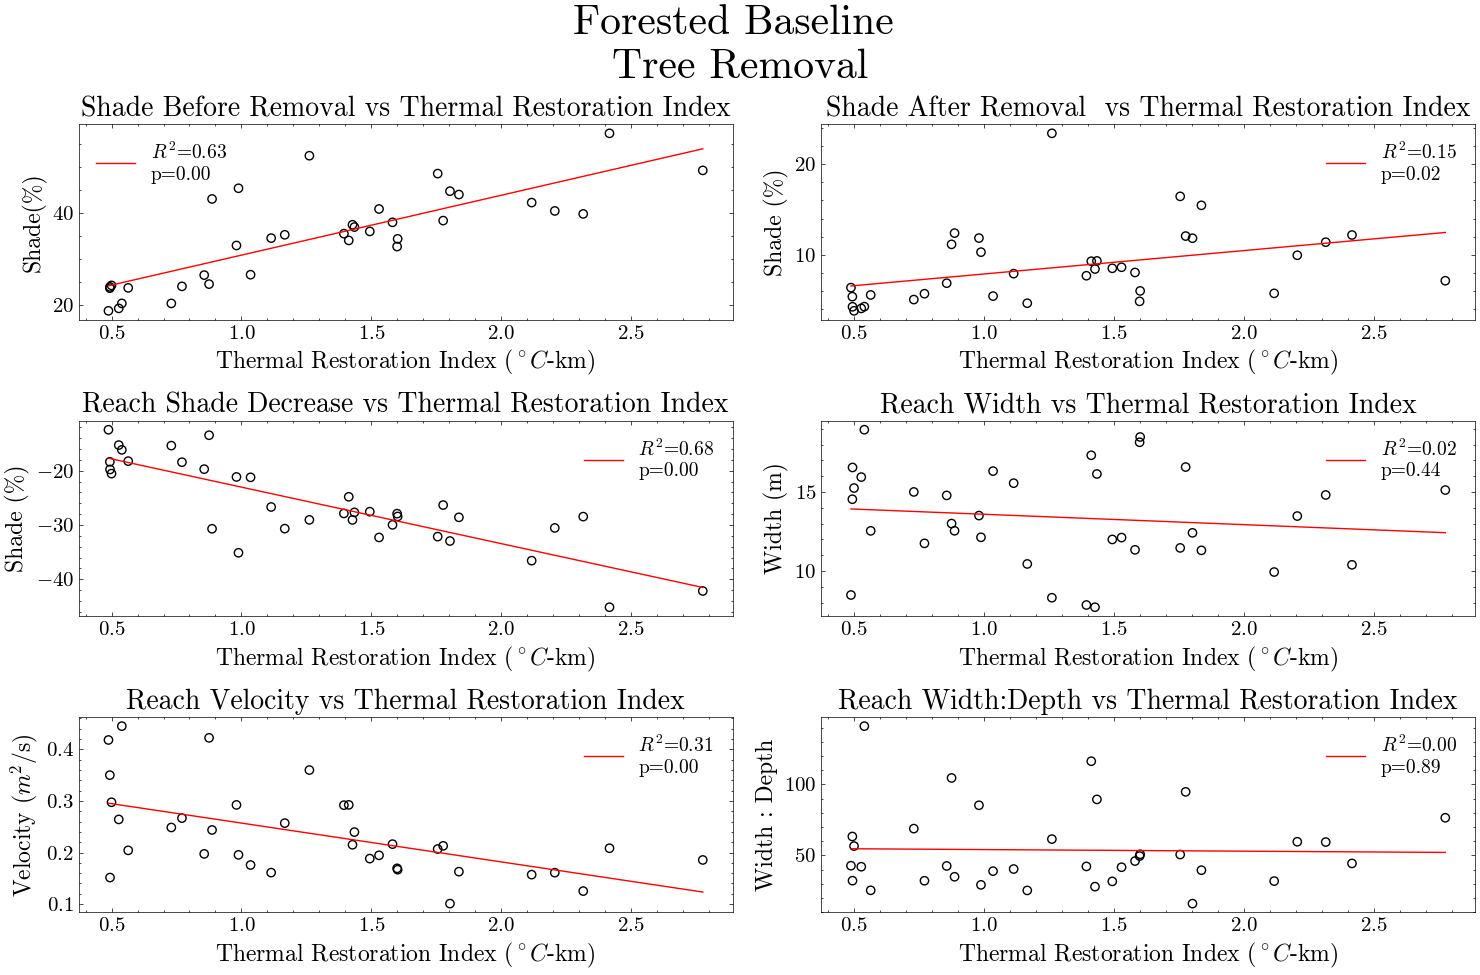

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress

# Assuming dif_df_dict contains your data

# Define a function for plotting
def plot_scatter_and_regression(x_data, y_data, x_label, y_title, y_label, ax):
    with plt.style.context(['science', 'no-latex']):
        #x_data = x_data*-1
        # Fitting linear regression
        model = LinearRegression()
        model.fit(x_data, y_data)
        r_squared = model.score(x_data, y_data)

        # Calculate p-value
        slope, intercept, r_value, p_value, std_err = linregress(x_data.ravel(), y_data)

        # Scatter plot
        ax.scatter(x_data, y_data, facecolors='none', edgecolors='black')

        # Plotting the regression line
        ax.plot(x_data, model.predict(x_data), color='red', linestyle = '-',label=f'$R^2$={r_squared:.2f} \np={p_value:.2f}')
        ax.set_title(y_title+ ' vs Thermal Restoration Index', fontsize = 20)
        # Labels and legend
        ax.set_xlabel(x_label, fontsize = 17)
        ax.set_ylabel(y_label, fontsize = 17)
        ax.tick_params(axis='both', which='major', labelsize=15)

        ax.legend(fontsize = 14)
with plt.style.context(['science', 'no-latex']):
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(3, 2, figsize=(15, 10))
    fig.suptitle('Forested Baseline \nTree Removal', fontsize=30)

    # Plot 1
    plot_scatter_and_regression(dif_df_dict['Degree Kilometers'].values.reshape(-1, 1),
                                 dif_df_dict['Baseline SR'].values,
                                 'Thermal Restoration Index (${^\circ}C$-km)', 'Shade Before Removal',  'Shade(%)', axs[0, 0])

    plot_scatter_and_regression(dif_df_dict['Degree Kilometers'].values.reshape(-1, 1),
                                 dif_df_dict['Scenario SR'].values,
                                 'Thermal Restoration Index (${^\circ}C$-km)', 'Shade After Removal ', 'Shade (%)', axs[0, 1])

    plot_scatter_and_regression(dif_df_dict['Degree Kilometers'].values.reshape(-1, 1),
                                 dif_df_dict['Change in SR'].values,
                                 'Thermal Restoration Index (${^\circ}C$-km)', 'Reach Shade Decrease', 'Shade (%)', axs[1, 0])

    # Plot 2 (Assuming you have dif_df_dict2, dif_df_dict3, dif_df_dict4 for other data)
    # Adjust accordingly based on your actual data
    plot_scatter_and_regression(dif_df_dict['Degree Kilometers'].values.reshape(-1, 1),
                                 dif_df_dict['Width'].values,
                                 'Thermal Restoration Index (${^\circ}C$-km)', 'Reach Width', 'Width (m)', axs[1, 1])

    # Plot 3
    plot_scatter_and_regression(dif_df_dict['Degree Kilometers'].values.reshape(-1, 1),
                                dif_df_dict['Mean velocity'].values,
                                 'Thermal Restoration Index (${^\circ}C$-km)', 'Reach Velocity', 'Velocity ($m{^2}$/s)', axs[2, 0])

    # Plot 4
    plot_scatter_and_regression(dif_df_dict['Degree Kilometers'].values.reshape(-1, 1),
                                 dif_df_dict['Width:Depth'].values,
                                 'Thermal Restoration Index (${^\circ}C$-km)', 'Reach Width:Depth', 'Width : Depth', axs[2, 1])

    # Adjust layout
    plt.tight_layout()
    plt.savefig(os.path.join(script_dir, 'Figures', 'TreeRemovalRegressionUpdate.png'), bbox_inches='tight', dpi=300)
    # Show plot
    plt.show()

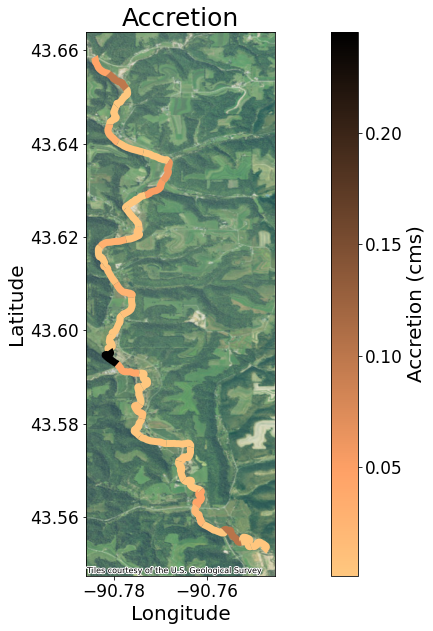

In [126]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import contextily as ctx
import geopandas as gpd
import scienceplots

# Define the original colormap
original_cmap = plt.cm.copper
degree_cmap = plt.cm.RdBu
inverted_degree_cmap = degree_cmap.reversed()

# Invert the colormap
inverted_cmap = original_cmap.reversed()

# Define the boundaries for the colorbar steps
bounds_accretion = [merged_gdf_dif['Accretion'].min(), merged_gdf_dif['Accretion'].max()]  

# Create a colormap norm with the defined boundaries
norm1 = mcolors.Normalize(vmin=merged_gdf_dif['Accretion'].min(), vmax=merged_gdf_dif['Accretion'].max())

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the GeoDataFrame on the axis with specified colormap and normalization
merged_gdf_dif.to_crs(epsg=4326).plot(column='Accretion', cmap=inverted_cmap, linewidth=7, norm=norm1, ax=ax)

# Add basemap using contextily
ctx.add_basemap(ax, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)

# Set labels and title
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
ax.set_title('Accretion', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=17)

cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm1, cmap=inverted_cmap), ax=ax, orientation='vertical')
cbar.set_label('Accretion (cms)', fontsize=20)
cbar.ax.tick_params(axis='both', which='major', labelsize=17)
# Show the plot
plt.show()


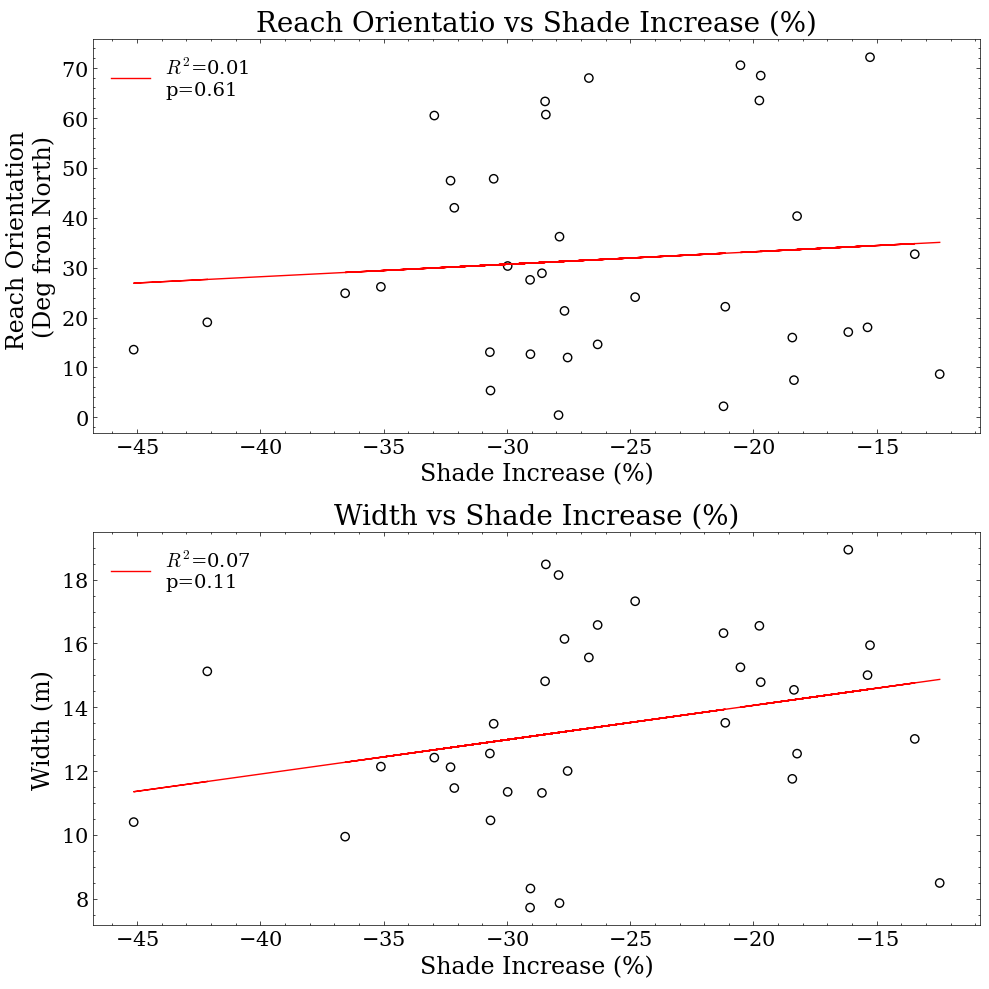

In [25]:
# Define a function for plotting
def plot_scatter_and_regression(x_data, y_data, x_label, y_title, y_label, ax):
    with plt.style.context(['science', 'no-latex']):
        #x_data = x_data*-1
        # Fitting linear regression
        model = LinearRegression()
        model.fit(x_data, y_data)
        r_squared = model.score(x_data, y_data)

        # Calculate p-value
        slope, intercept, r_value, p_value, std_err = linregress(x_data.ravel(), y_data)

        # Scatter plot
        ax.scatter(x_data, y_data, facecolors='none', edgecolors='black')

        # Plotting the regression line
        ax.plot(x_data, model.predict(x_data), color='red', linestyle = '-',label=f'$R^2$={r_squared:.2f} \np={p_value:.2f}')
        ax.set_title(y_title + ' vs '+ x_label, fontsize = 20)
        # Labels and legend
        ax.set_xlabel(x_label, fontsize = 17)
        ax.set_ylabel(y_label, fontsize = 17)
        ax.tick_params(axis='both', which='major', labelsize=15)

        ax.legend(fontsize = 14)

with plt.style.context(['science', 'no-latex']):
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    #fig.suptitle('Influence of Width \nand Channel Orientation on Shade', fontsize=30)

    # Plot 1
    plot_scatter_and_regression(dif_df_dict['Change in SR'].values.reshape(-1, 1),
                                 dif_df_dict['Mean Azimuth'].values,
                                 'Shade Increase (%)', 'Reach Orientatio', 'Reach Orientation \n(Deg fron North)', axs[0])
    #plot 2
    plot_scatter_and_regression(dif_df_dict['Change in SR'].values.reshape(-1, 1),
                                 dif_df_dict['Width'].values,
                                 'Shade Increase (%)', 'Width', 'Width (m)', axs[1])
    plt.tight_layout()
    #plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\500mTreeRemovalEffectiveness_orientation.png', bbox_inches = 'tight', dpi = 300)


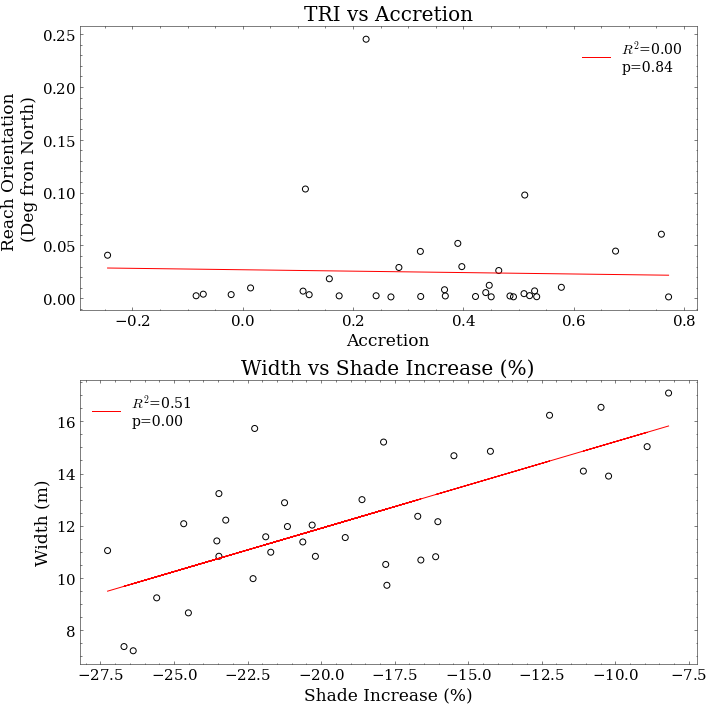

In [133]:
# Define a function for plotting
def plot_scatter_and_regression(x_data, y_data, x_label, y_title, y_label, ax):
    with plt.style.context(['science', 'no-latex']):
        #x_data = x_data*-1
        # Fitting linear regression
        model = LinearRegression()
        model.fit(x_data, y_data)
        r_squared = model.score(x_data, y_data)

        # Calculate p-value
        slope, intercept, r_value, p_value, std_err = linregress(x_data.ravel(), y_data)

        # Scatter plot
        ax.scatter(x_data, y_data, facecolors='none', edgecolors='black')

        # Plotting the regression line
        ax.plot(x_data, model.predict(x_data), color='red', linestyle = '-',label=f'$R^2$={r_squared:.2f} \np={p_value:.2f}')
        ax.set_title(y_title + ' vs '+ x_label, fontsize = 20)
        # Labels and legend
        ax.set_xlabel(x_label, fontsize = 17)
        ax.set_ylabel(y_label, fontsize = 17)
        ax.tick_params(axis='both', which='major', labelsize=15)

        ax.legend(fontsize = 14)

with plt.style.context(['science', 'no-latex']):
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    #fig.suptitle('Influence of Width \nand Channel Orientation on Shade', fontsize=30)

    # Plot 1
    plot_scatter_and_regression(dif_df_dict['Degree Kilometers'].values.reshape(-1, 1),
                                 dif_df_dict['Accretion'].values,
                                 'Accretion', 'TRI', 'Reach Orientation \n(Deg fron North)', axs[0])
    #plot 2
    plot_scatter_and_regression(dif_df_dict['Change in SR'].values.reshape(-1, 1),
                                 dif_df_dict['Width'].values,
                                 'Shade Increase (%)', 'Width', 'Width (m)', axs[1])
    plt.tight_layout()
    #plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\500mTreeRemovalEffectiveness_orientation.png', bbox_inches = 'tight', dpi = 300)


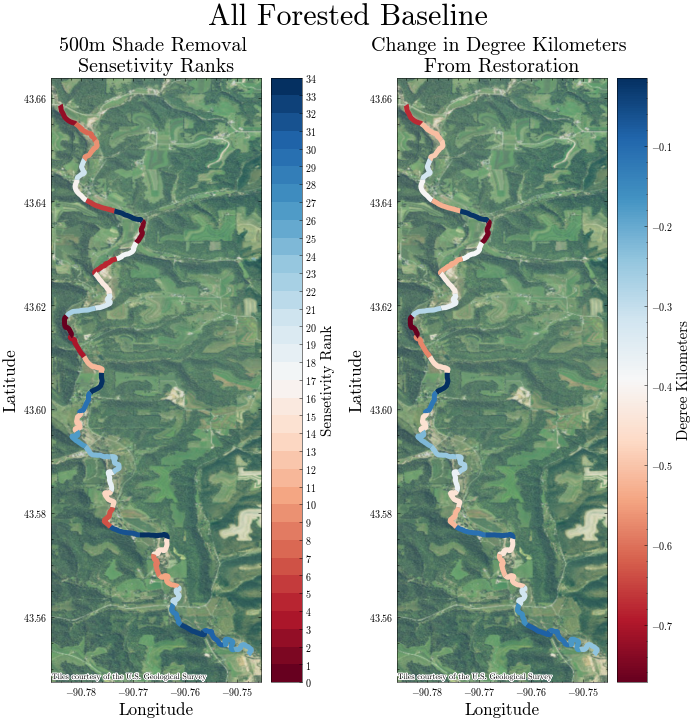

In [273]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import contextily as ctx
import scienceplots
# Define the original colormap
original_cmap = plt.cm.RdBu

# Invert the colormap
inverted_cmap = original_cmap.reversed()

# Define the boundaries for the colorbar steps
bounds = list(range(0, 35))  # Example boundaries
bounds_dif = [merged_gdf_dif['Degree Kilometers'].min(), merged_gdf_dif['Degree Kilometers'].max()]

# Create a colormap norm with the defined boundaries
norm = mcolors.BoundaryNorm(bounds, inverted_cmap.N)

# Create a colormap norm with the defined boundaries for the second plot
norm2 = mcolors.Normalize(vmin=merged_gdf_dif['Degree Kilometers'].min(), vmax=merged_gdf_dif['Degree Kilometers'].max())
with plt.style.context(['science', 'no-latex']):

    # plotting the difference in temps between modeled reaches, with ranking
    fig, axes = plt.subplots(1, 2, figsize=(20, 10), layout = 'compressed')
    fig.suptitle('All Forested Baseline', fontsize=30)



    db_lonlat = merged_gdf_dif.to_crs(epsg=4326)
    ctx.add_basemap(ax, crs=db_lonlat.crs)
    # Plot the first map
    ax1 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Effectiveness Rank', cmap=original_cmap, linewidth=5, ax=axes[0], norm=norm)
    ctx.add_basemap(ax1, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax1.set_xlabel('Longitude', fontsize = 17)
    ax1.set_ylabel('Latitude', fontsize = 17)
    ax1.set_title('500m Shade Removal \nSensetivity Ranks', fontsize = 20)

    # Plot the second map
    ax2 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Degree Kilometers', cmap=original_cmap, linewidth=5,ax=axes[1], norm=norm2)
    ctx.add_basemap(ax2, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax2.set_title('Change in Degree Kilometers \nFrom Restoration', fontsize = 20)
    ax2.set_xlabel('Longitude', fontsize = 17)
    ax2.set_ylabel('Latitude', fontsize = 17)
    # Add colorbars for clarity
    cbar1 = plt.colorbar(mappable=axes[0].collections[0], ax=axes[0], orientation='vertical', boundaries=bounds, ticks=bounds)
    cbar1.set_label('Sensetivity Rank', fontsize = 15)

    cbar2 = plt.colorbar(mappable=axes[1].collections[0], ax=axes[1], orientation='vertical')
    cbar2.set_label('Degree Kilometers', fontsize = 15)
    plt.subplots_adjust(wspace=0)  # Adjust the width space between subplots

    plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\500mTreeRemovalEffectiveness.png', bbox_inches = 'tight', dpi = 300)
    plt.show()


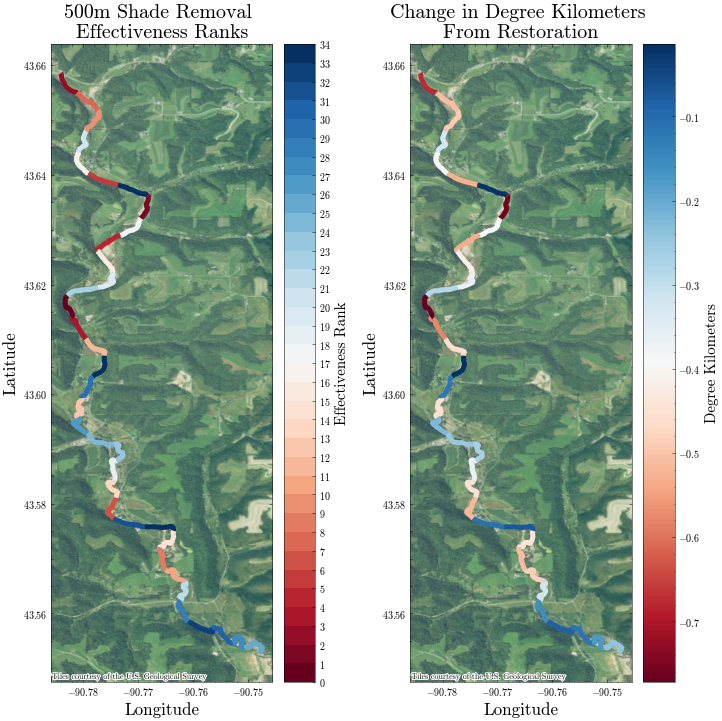

In [245]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import contextily as ctx

# Define the original colormap
original_cmap = plt.cm.RdBu

# Invert the colormap
inverted_cmap = original_cmap.reversed()

# Define the boundaries for the colorbar steps
bounds = list(range(0, 35))  # Example boundaries
bounds_dif = [merged_gdf_dif['Degree Kilometers'].min(), merged_gdf_dif['Degree Kilometers'].max()]

# Create a colormap norm with the defined boundaries
norm = mcolors.BoundaryNorm(bounds, inverted_cmap.N)

# Create a colormap norm with the defined boundaries for the second plot
norm2 = mcolors.Normalize(vmin=merged_gdf_dif['Degree Kilometers'].min(), vmax=merged_gdf_dif['Degree Kilometers'].max())
with plt.style.context(['science', 'no-latex']):

    # plotting the difference in temps between modeled reaches, with ranking
    fig, axes = plt.subplots(1, 2, figsize=(20, 10), layout = 'compressed')


    db_lonlat = merged_gdf_dif.to_crs(epsg=4326)
    ctx.add_basemap(ax, crs=db_lonlat.crs)
    # Plot the first map
    ax1 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Effectiveness Rank', cmap=original_cmap, linewidth=5, ax=axes[0], norm=norm)
    ctx.add_basemap(ax1, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax1.set_xlabel('Longitude', fontsize = 17)
    ax1.set_ylabel('Latitude', fontsize = 17)
    ax1.set_title('500m Shade Removal \nEffectiveness Ranks', fontsize = 20)

    # Plot the second map
    ax2 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Degree Kilometers', cmap=original_cmap, linewidth=5,ax=axes[1], norm=norm2)
    ctx.add_basemap(ax2, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax2.set_title('Change in Degree Kilometers \nFrom Restoration', fontsize = 20)
    ax2.set_xlabel('Longitude', fontsize = 17)
    ax2.set_ylabel('Latitude', fontsize = 17)
    # Add colorbars for clarity
    cbar1 = plt.colorbar(mappable=axes[0].collections[0], ax=axes[0], orientation='vertical', boundaries=bounds, ticks=bounds)
    cbar1.set_label('Effectiveness Rank', fontsize = 15)

    cbar2 = plt.colorbar(mappable=axes[1].collections[0], ax=axes[1], orientation='vertical')
    cbar2.set_label('Degree Kilometers', fontsize = 15)
    plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\500mTreeRemovalEffectiveness.png', bbox_inches = 'tight', dpi = 300)
    plt.show()


In [ ]:
### Plotting Change in Hours above MWAT Threshold

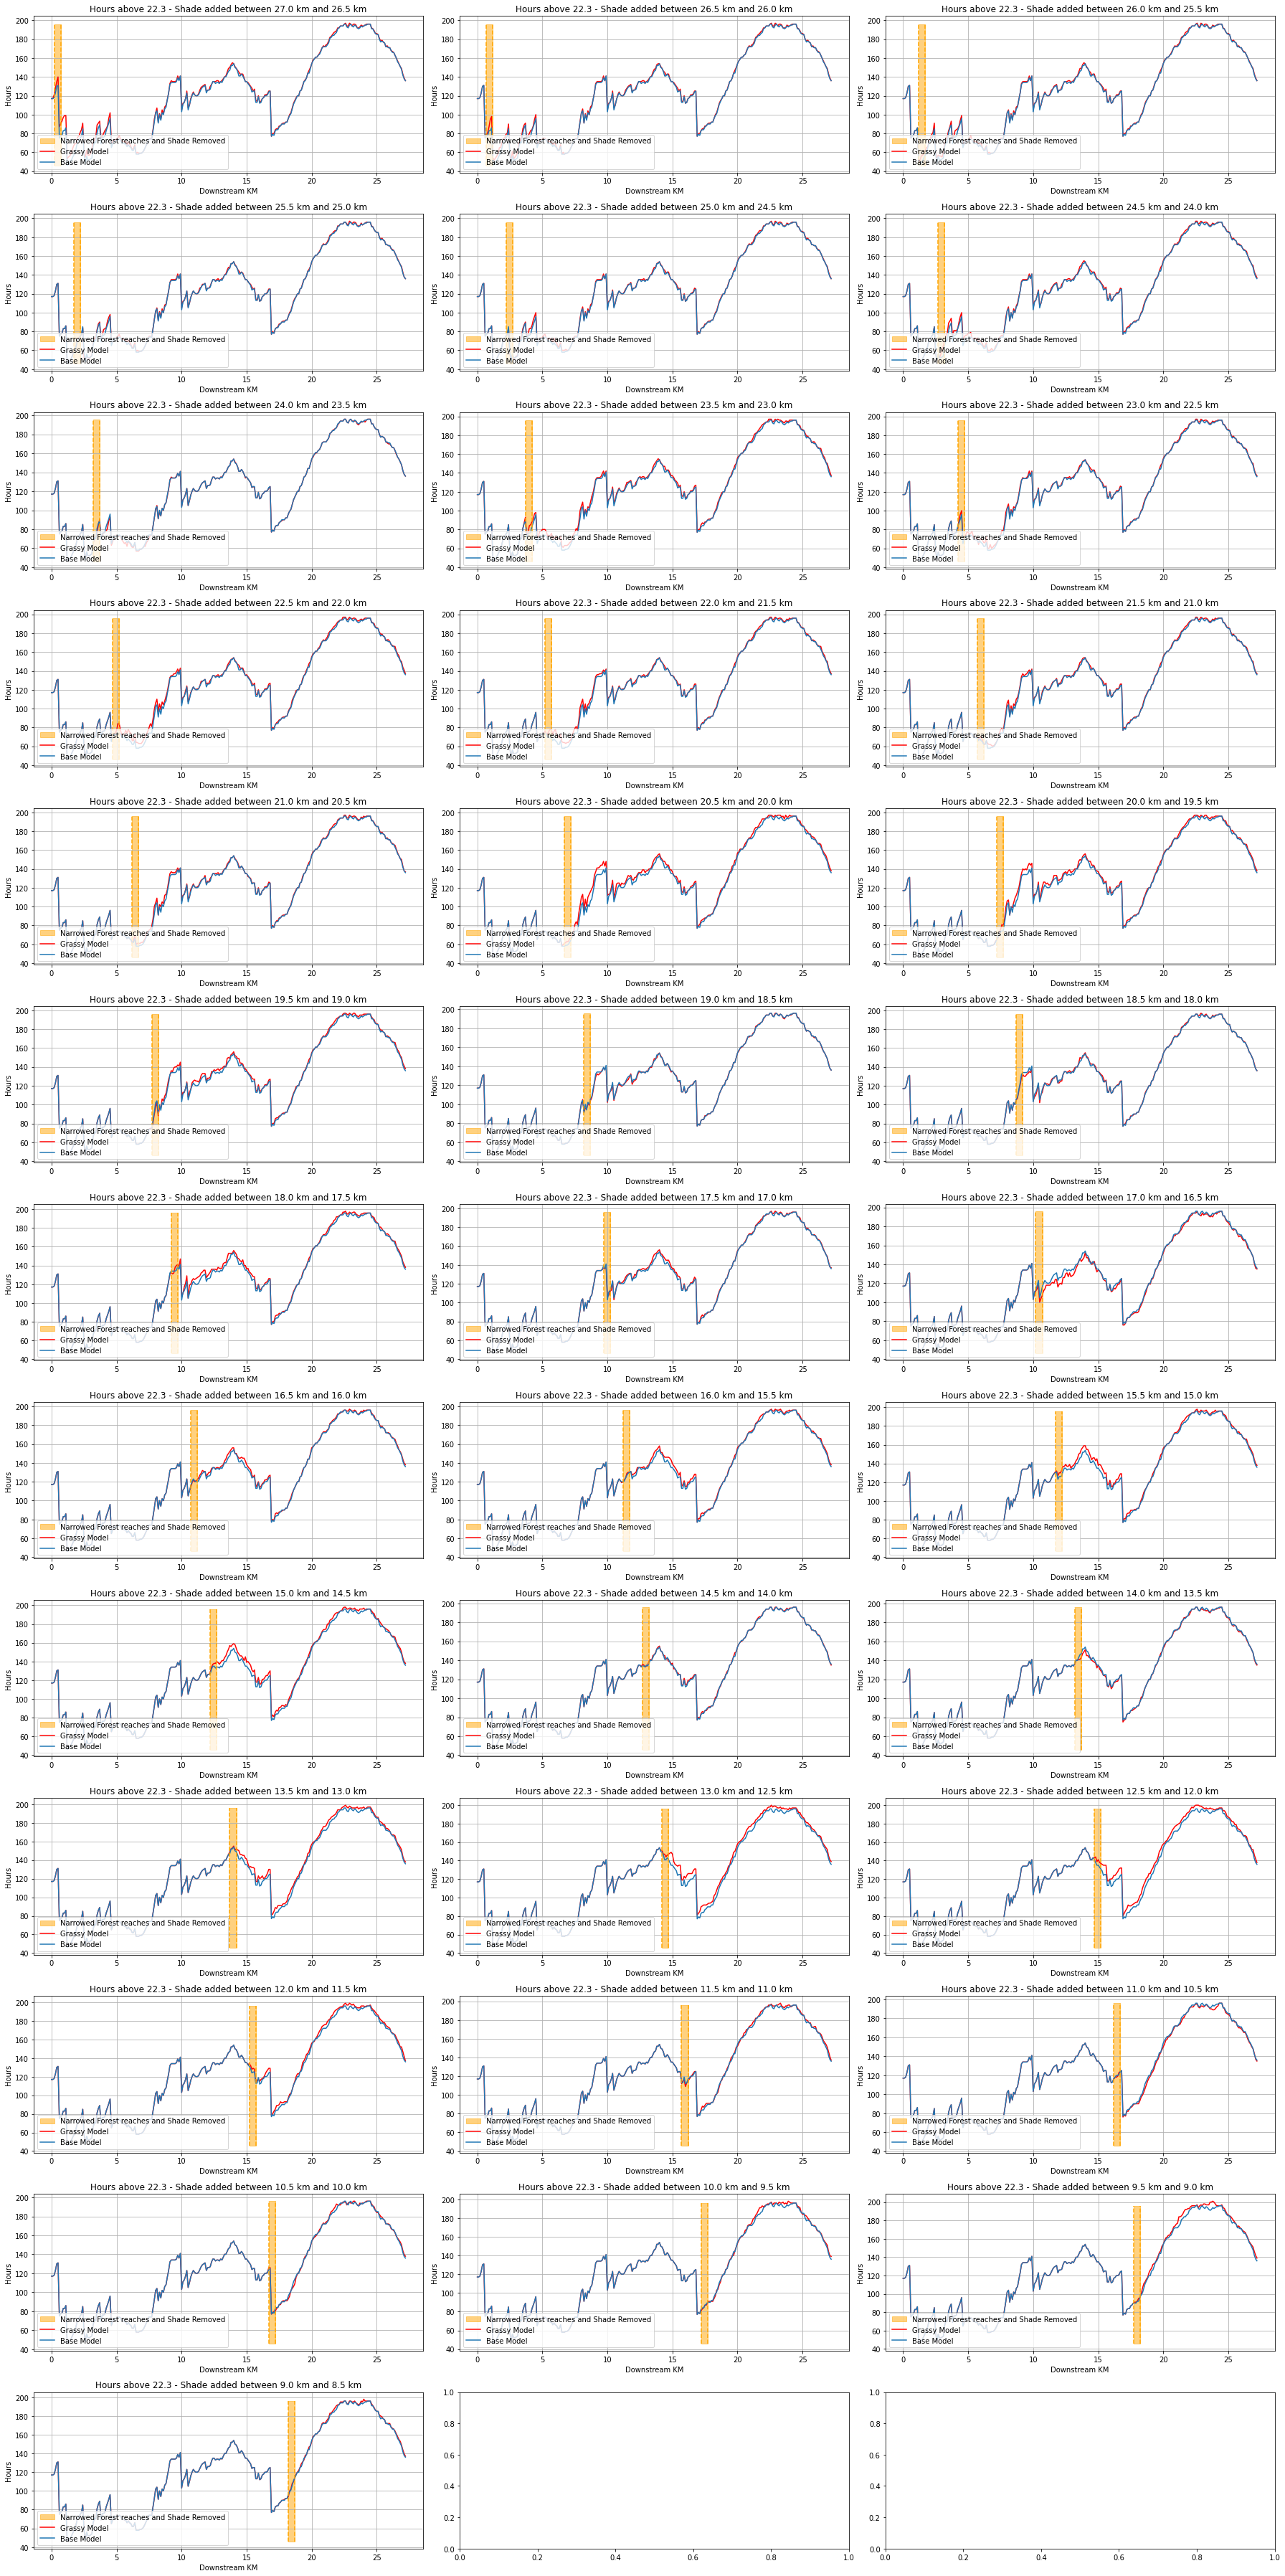

In [244]:
upstreamconstant_df = pd.read_csv(os.path.join(r'D:\\Ben_wd\\THESIS\\heatsource\WestFork\\ModelRuns\\Hayes\\scenarios\\thesis_scenarios\\extending_model\\allshade_extended_monthly', 'outputs', 'Temp_H2O.csv'), skiprows=6, usecols=range(1, 274))
upstreamconstant_df.columns = [float(col) for col in upstreamconstant_df.columns]
upstreamconstant_df.index = obs_clip.index
# mean july temperature summary
upstreamconstant_modeled = upstreamconstant_df.resample('D').mean()
# upstreamconstant_modeled = upstreamconstant_df.resample('D').sum()

upstreamconstant_modeled = upstreamconstant_modeled.mean()    
upstreamconstant_modeled = pd.DataFrame(upstreamconstant_modeled)
upstreamconstant_modeled = upstreamconstant_modeled.reset_index()
upstreamconstant_modeled.rename(columns={'index': 'NODE_ID', 0 : 'Mean July Temp'}, inplace=True)
base_hours_above_25 = upstreamconstant_df.apply(lambda col: (col > 23.3).sum())
base_hours_above_25 = pd.DataFrame(base_hours_above_25)

upstreamconstant_modeled = pd.merge(upstreamconstant_modeled, base_hours_above_25, left_on = 'NODE_ID', right_index = True, how = 'left')
upstreamconstant_modeled.rename(columns={0: 'hrs above 25'}, inplace=True)


count = 0
fig, axes = plt.subplots(13, 3, figsize=(25, 50))

    # Flatten the axes array to make it easier to iterate over
axes = axes.flatten()
for i in values:
    count += 1
    km_start = i
    km_end = i-.5
    if km_start == 0:
        continue
    else:
        # km_start = i+1
        # km_end = i
        reach_source_folder =  f"D:\\Ben_wd\\THESIS\\heatsource\WestFork\\ModelRuns\\Hayes\\scenarios\\thesis_scenarios\\results\\monthly500m_treeremoval\\treeremoval_widening_{i}"
        modeled_tw_df = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Temp_H2O.csv'), skiprows=6, usecols=range(1, 274))
        modeled_tw_df.columns = [float(col) for col in modeled_tw_df.columns]
        modeled_tw_df.index = obs_clip.index
        mean_daily_modeled = modeled_tw_df.resample('D').mean()
        mean_july_modeled = mean_daily_modeled.mean()    
        mean_july_modeled = pd.DataFrame(mean_july_modeled)
        mean_july_modeled = mean_july_modeled.reset_index()
        mean_july_modeled.rename(columns={'index': 'NODE_ID', 0 : 'Mean July Temp'}, inplace=True)
        hours_above_25 = modeled_tw_df.apply(lambda col: (col > 23.3).sum())
        hours_above_25 = pd.DataFrame(hours_above_25)

        mean_july_modeled = pd.merge(mean_july_modeled, hours_above_25, left_on = 'NODE_ID', right_index = True, how = 'left')
        mean_july_modeled.rename(columns={0: 'hrs above 25'}, inplace=True)
        shade_start = i
        #plt.figure()  # Create a new figure for each iteration  
        axes[count-1].fill_between([27.2 - km_start, 27.2 - km_end], upstreamconstant_modeled['hrs above 25'].min(),upstreamconstant_modeled['hrs above 25'].max(), color='orange', alpha = .5, label = 'Narrowed Forest reaches and Shade Removed')
        axes[count-1].plot(27.2-mean_july_modeled['NODE_ID'], mean_july_modeled['hrs above 25'], label=f'Grassy Model', color = 'red')
        axes[count-1].plot(27.2-upstreamconstant_modeled['NODE_ID'], upstreamconstant_modeled['hrs above 25'], label='Base Model')
        axes[count-1].set_title(f'Hours above 22.3 - Shade added between {km_start} km and {km_end} km')
        axes[count-1].set_xlabel('Downstream KM')  # Replace 'X Label' with appropriate label
        axes[count-1].set_ylabel('Hours')  # Replace 'Y Label' with appropriate label


        axes[count-1].vlines([27.2 - km_start, 27.2 - km_end], ymin = upstreamconstant_modeled['hrs above 25'].min(), ymax = upstreamconstant_modeled['hrs above 25'].max(),color = 'orange', linestyles = 'dashed')
        axes[count-1].grid(True) 
        axes[count-1].legend(loc = 'lower left') 
        
plt.tight_layout()
fig.patch.set_facecolor('white')

#plt.savefig(r'D:/Ben_wd/THESIS/heatsource/WestFork/ModelRuns/Hayes/scenarios/thesis_scenarios/500m_run/narrow/reach_shaderemoval+narrow20.png')
plt.show()
